# Pruebas métodos clásicos/estadísticos

In [ ]:
import pandas as pd

import numpy as np
from datetime import datetime

# Load train and test CSV files into DataFrames
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

train_df.sample(10)

,user,item,rating
48215,5694,123752,5.0
53954,6707,135679,5.0
109904,17090,49958,10.0
378403,75011,26465,7.0
66051,8368,45151,6.0
72731,9378,115860,10.0
272152,51567,139080,8.0
40666,4475,26052,9.0
92403,12864,31099,7.0
244532,45816,58749,5.0


In [10]:
rating_distribution = train_df['rating'].value_counts().sort_index()
print(rating_distribution)

1.0      1592
2.0      2478
3.0      5423
4.0      8042
5.0     45231
6.0     33489
7.0     69102
8.0     93366
9.0     60507
10.0    71121
Name: rating, dtype: int64


## Predecir usando distribuciones probabilisticas

In [ ]:
# Normalize the rating distribution to get probabilities
rating_probs = rating_distribution / rating_distribution.sum()

# Generate ratings for the test DataFrame based on the train distribution
test_df['rating'] = np.random.choice(rating_distribution.index, size=len(test_df), p=rating_probs)

# Prepare the output file path with a timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_path = f'../out/result_{timestamp}.csv'

# Export the result to an Excel file
test_df[['ID', 'rating']].to_csv(output_path, index=False)

print(f"File saved to {output_path}")
test_df.sample(10)

File saved to ../out/result_20250327_202144.csv


,ID,user,item,rating
6011,6011,279,592,6.0
12159,12159,4244,13666,8.0
26466,26466,3814,11350,8.0
12322,12322,4943,2843,9.0
32978,32978,9269,986,7.0
42136,42136,2496,5186,8.0
31712,31712,4201,13382,8.0
42910,42910,9707,13030,9.0
5916,5916,2058,7630,8.0
21979,21979,8793,267,7.0


## Predecir con la moda

In [14]:
# Calcular la moda de las calificaciones en el DataFrame de entrenamiento
rating_mode = train_df['rating'].mode()[0]

# Asignar la moda como calificación para todos los registros en el DataFrame de prueba
test_df['rating'] = rating_mode

# Exportar el resultado a un archivo CSV
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_path = f'../out/result_{timestamp}.csv'
test_df[['ID', 'rating']].to_csv(output_path, index=False)

print(f"File saved to {output_path}")
test_df.sample(10)

File saved to ../out/result_20250327_202401.csv


,ID,user,item,rating
39318,39318,5353,15739,8.0
22481,22481,9475,4925,8.0
24353,24353,7836,2190,8.0
33426,33426,534,1847,8.0
30959,30959,1907,4405,8.0
8771,8771,593,3782,8.0
36209,36209,10657,24630,8.0
28985,28985,5659,11791,8.0
14150,14150,3154,5708,8.0
9253,9253,7906,9151,8.0


## KNN

In [ ]:
import pandas as pd
import numpy as np
import math
import csv
from collections import defaultdict

# Configuración
K = 15
MIN_RATING = 0
MAX_RATING = 10

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# Mapeo de IDs
user_ids = sorted(set(df_train['user']).union(df_test['user']))
item_ids = sorted(set(df_train['item']).union(df_test['item']))
user_to_index = {uid: idx for idx, uid in enumerate(user_ids)}
item_to_index = {iid: idx for idx, iid in enumerate(item_ids)}

# Número total
NUM_USERS = len(user_ids)
NUM_ITEMS = len(item_ids)

# Matriz dispersa: (u, i) -> rating
ratings = {}
user_items = defaultdict(set)
item_users = defaultdict(set)

for _, row in df_train.iterrows():
    u = user_to_index[row['user']]
    i = item_to_index[row['item']]
    r = row['rating']
    ratings[(u, i)] = r
    user_items[u].add(i)
    item_users[i].add(u)

# Media de un usuario
def rating_average(u):
    votos = [ratings[(u, i)] for i in user_items[u]]
    return sum(votos) / len(votos) if votos else 0

# Similaridad JMSD
def jmsd_similarity(u, v):
    items_u = user_items[u]
    items_v = user_items[v]
    intersection = items_u & items_v
    union = items_u | items_v

    if not intersection:
        return None

    diff = 0
    for i in intersection:
        ru = (ratings[(u, i)] - MIN_RATING) / (MAX_RATING - MIN_RATING)
        rv = (ratings[(v, i)] - MIN_RATING) / (MAX_RATING - MIN_RATING)
        diff += (ru - rv) ** 2

    jaccard = len(intersection) / len(union)
    msd = diff / len(intersection)
    return jaccard * (1 - msd)

# Obtener K vecinos
def get_neighbors(u, i):
    neighbors = []
    for v in item_users[i]:  # solo usuarios que han votado el ítem
        if u == v:
            continue
        sim = jmsd_similarity(u, v)
        if sim is not None:
            neighbors.append((v, sim))
    neighbors.sort(key=lambda x: x[1], reverse=True)
    return neighbors[:K]

# Agregación: media simple
def average_prediction(u, i, neighbors):
    ratings_sum = 0
    count = 0
    for v, _ in neighbors:
        if (v, i) in ratings:
            ratings_sum += ratings[(v, i)]
            count += 1
    return ratings_sum / count if count > 0 else None

# Predicciones para test
output_rows = []

for _, row in df_test.iterrows():
    test_id = row['ID']
    u_raw = row['user']
    i_raw = row['item']

    u = user_to_index.get(u_raw)
    i = item_to_index.get(i_raw)

    if u is not None and i is not None:
        neighbors = get_neighbors(u, i)
        pred = average_prediction(u, i, neighbors)
        pred = round(max(MIN_RATING, min(MAX_RATING, pred)), 3) if pred is not None else 8.0
    else:
        pred = 8.0  # Valor por defecto si no se puede calcular (moda)

    output_rows.append((test_id, pred))

# Guardar resultados
with open("predicciones_KNN_sparse.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "rating"])
    writer.writerows(output_rows)

print("Archivo 'predicciones_KNN_sparse.csv' generado correctamente.")

Archivo 'predicciones_KNN_sparse.csv' generado correctamente.


### Hiperparámetros

In [ ]:
import pandas as pd
import numpy as np
import math
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Configuración
MIN_RATING = 0
MAX_RATING = 10
K_values = [5, 10, 15, 20, 25, 30, 35, 40]  # valores de K a probar

# Leer dataset original
df = pd.read_csv("train.csv")
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

# Preprocesado común
user_ids = sorted(set(df_train['user']).union(df_val['user']))
item_ids = sorted(set(df_train['item']).union(df_val['item']))
user_to_index = {uid: idx for idx, uid in enumerate(user_ids)}
item_to_index = {iid: idx for idx, iid in enumerate(item_ids)}
NUM_USERS = len(user_ids)
NUM_ITEMS = len(item_ids)

# Convertir a estructuras dispersas
ratings = {}
user_items = defaultdict(set)
item_users = defaultdict(set)

for _, row in df_train.iterrows():
    u = user_to_index[row['user']]
    i = item_to_index[row['item']]
    r = row['rating']
    ratings[(u, i)] = r
    user_items[u].add(i)
    item_users[i].add(u)

# Función: media de un usuario
def rating_average(u):
    votos = [ratings[(u, i)] for i in user_items[u]]
    return sum(votos) / len(votos) if votos else 0

# Similaridad JMSD
def jmsd_similarity(u, v):
    items_u = user_items[u]
    items_v = user_items[v]
    intersection = items_u & items_v
    union = items_u | items_v
    if not intersection:
        return None
    diff = 0
    for i in intersection:
        ru = (ratings[(u, i)] - MIN_RATING) / (MAX_RATING - MIN_RATING)
        rv = (ratings[(v, i)] - MIN_RATING) / (MAX_RATING - MIN_RATING)
        diff += (ru - rv) ** 2
    jaccard = len(intersection) / len(union)
    msd = diff / len(intersection)
    return jaccard * (1 - msd)

# Obtener K vecinos
def get_neighbors(u, i, K):
    neighbors = []
    for v in item_users[i]:
        if u == v:
            continue
        sim = jmsd_similarity(u, v)
        if sim is not None:
            neighbors.append((v, sim))
    neighbors.sort(key=lambda x: x[1], reverse=True)
    return neighbors[:K]

# Agregación: media simple
def average_prediction(u, i, neighbors):
    ratings_sum = 0
    count = 0
    for v, _ in neighbors:
        if (v, i) in ratings:
            ratings_sum += ratings[(v, i)]
            count += 1
    return ratings_sum / count if count > 0 else None

# Evaluación MAE en validación
def evaluate_mae(K):
    errors = []
    for _, row in df_val.iterrows():
        u = user_to_index.get(row['user'])
        i = item_to_index.get(row['item'])
        true_rating = row['rating']
        if u is not None and i is not None:
            neighbors = get_neighbors(u, i, K)
            pred = average_prediction(u, i, neighbors)
            if pred is not None:
                pred = max(MIN_RATING, min(MAX_RATING, pred))
                errors.append(abs(true_rating - pred))
    return np.mean(errors) if errors else None

# Búsqueda de hiperparámetros
best_k = None
best_mae = float("inf")

print("Iniciando búsqueda de hiperparámetros...\n")
for k in K_values:
    print(f"Evaluando K = {k}")
    mae = evaluate_mae(k)
    print(f"MAE con K = {k}: {mae:.4f}")
    if mae < best_mae:
        best_mae = mae
        best_k = k

print("\nMejor valor encontrado:")
print(f"K = {best_k} con MAE = {best_mae:.4f}")

Iniciando búsqueda de hiperparámetros...

Evaluando K = 5
MAE con K = 5: 1.5940
Evaluando K = 10
MAE con K = 10: 1.5844
Evaluando K = 15
MAE con K = 15: 1.5837
Evaluando K = 20
MAE con K = 20: 1.5839
Evaluando K = 25
MAE con K = 25: 1.5845
Evaluando K = 30
MAE con K = 30: 1.5848
Evaluando K = 35
MAE con K = 35: 1.5851
Evaluando K = 40
MAE con K = 40: 1.5852

Mejor valor encontrado:
K = 15 con MAE = 1.5837


## PMF

In [ ]:
# Parámetros del modelo
NUM_FACTORS = 7
LEARNING_RATE = 0.001
REGULARIZATION = 0.1
NUM_ITERATIONS = 10
MIN_RATING = 0
MAX_RATING = 10

### Hiperparámetros

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir datos de entrenamiento en train + validación
train_data, val_data = train_test_split(df_train, test_size=0.2, random_state=42)

#### GridSearch (loky)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
from joblib import Parallel, delayed
import csv
from collections import defaultdict

# Cargar datos completos
df = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

# Dividir en entrenamiento y validación
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

# Indexado de usuarios e ítems
user_ids = sorted(set(df_train['user']).union(df_val['user']).union(df_test['user']))
item_ids = sorted(set(df_train['item']).union(df_val['item']).union(df_test['item']))

user_to_index = {uid: idx for idx, uid in enumerate(user_ids)}
item_to_index = {iid: idx for idx, iid in enumerate(item_ids)}

NUM_USERS = len(user_ids)
NUM_ITEMS = len(item_ids)

# Diccionarios para ratings
ratings = {}
user_items = defaultdict(set)

for _, row in df_train.iterrows():
    u = user_to_index[row['user']]
    i = item_to_index[row['item']]
    r = row['rating']
    ratings[(u, i)] = r
    user_items[u].add(i)

# Media de las valoraciones
rating_average = sum(ratings.values()) / len(ratings)

# Búsqueda de hiperparámetros
param_grid = {
    'NUM_FACTORS': [5, 10, 15, 20],
    'NUM_ITERATIONS': [10, 20, 30, 50],
    'LEARNING_RATE': [0.001, 0.005, 0.01],
    'REGULARIZATION': [0.01, 0.1, 0.5]
}

# Función para entrenar el modelo y calcular MAE
def train_and_evaluate(params):
    p = np.random.rand(NUM_USERS, params['NUM_FACTORS'])
    q = np.random.rand(NUM_ITEMS, params['NUM_FACTORS'])
    bu = np.random.rand(NUM_USERS)
    bi = np.random.rand(NUM_ITEMS)

    def compute_biased_prediction(avg, b_u, b_i, p_u, q_i):
        return avg + b_u + b_i + np.dot(p_u, q_i)

    # Entrenamiento
    for it in range(params['NUM_ITERATIONS']):
        for (u, i), rating in ratings.items():
            pred = compute_biased_prediction(rating_average, bu[u], bi[i], p[u], q[i])
            error = rating - pred

            bu[u] += params['LEARNING_RATE'] * (error - params['REGULARIZATION'] * bu[u])
            bi[i] += params['LEARNING_RATE'] * (error - params['REGULARIZATION'] * bi[i])

            p[u] += params['LEARNING_RATE'] * (error * q[i] - params['REGULARIZATION'] * p[u])
            q[i] += params['LEARNING_RATE'] * (error * p[u] - params['REGULARIZATION'] * q[i])

    # Evaluación con el conjunto de validación
    val_mae = []
    for _, row in df_val.iterrows():
        u_raw, i_raw, actual_rating = row['user'], row['item'], row['rating']
        u = user_to_index.get(u_raw)
        i = item_to_index.get(i_raw)
        if u is not None and i is not None:
            pred = compute_biased_prediction(rating_average, bu[u], bi[i], p[u], q[i])
            val_mae.append(abs(actual_rating - pred))

    mae = np.mean(val_mae) if val_mae else float('inf')
    print(f"Probando parámetros: {params} -> MAE: {mae}")
    return params, mae

# Paralelización de la búsqueda de hiperparámetros
results = Parallel(n_jobs=12, backend="loky")(delayed(train_and_evaluate)(params) for params in ParameterGrid(param_grid))

# Obtener los mejores parámetros
best_params, best_mae = min(results, key=lambda x: x[1])
print("Mejores hiperparámetros:", best_params)
print(f"Mejor MAE: {best_mae:.4f}")

Probando parámetros: {'LEARNING_RATE': 0.001, 'NUM_FACTORS': 5, 'NUM_ITERATIONS': 10, 'REGULARIZATION': 0.01} -> MAE: 1.7210371625398713
Probando parámetros: {'LEARNING_RATE': 0.001, 'NUM_FACTORS': 5, 'NUM_ITERATIONS': 10, 'REGULARIZATION': 0.1} -> MAE: 1.716158631243736
Probando parámetros: {'LEARNING_RATE': 0.001, 'NUM_FACTORS': 5, 'NUM_ITERATIONS': 10, 'REGULARIZATION': 0.5} -> MAE: 1.7020375498454894
Probando parámetros: {'LEARNING_RATE': 0.001, 'NUM_FACTORS': 5, 'NUM_ITERATIONS': 20, 'REGULARIZATION': 0.1} -> MAE: 1.6115365068247864
Probando parámetros: {'LEARNING_RATE': 0.001, 'NUM_FACTORS': 5, 'NUM_ITERATIONS': 20, 'REGULARIZATION': 0.01} -> MAE: 1.617581444700255
Probando parámetros: {'LEARNING_RATE': 0.001, 'NUM_FACTORS': 10, 'NUM_ITERATIONS': 10, 'REGULARIZATION': 0.01} -> MAE: 2.0442177182798154
Probando parámetros: {'LEARNING_RATE': 0.001, 'NUM_FACTORS': 5, 'NUM_ITERATIONS': 20, 'REGULARIZATION': 0.5} -> MAE: 1.599012222544092
Probando parámetros: {'LEARNING_RATE': 0.001, '

#### Ray Tune

Nos dio muchos problemas de versiones, configuración y recursos. Parece un framework muy prometedor ya que combina las mejores prácticas de otros métodos de busqueda de hiperparámetros, además de generar un informe en formato tabla muy interesante.

In [ ]:
import pandas as pd
import numpy as np
import csv
from ray import tune
from ray.tune.search.bayesopt import BayesOptSearch
from collections import defaultdict

# Parámetros del modelo
# Parámetros del modelo predeterminados
NUM_FACTORS = 20
LEARNING_RATE = 0.005
REGULARIZATION = 0.01
NUM_ITERATIONS = 50
MIN_RATING = 0
MAX_RATING = 10

# Cargar datos
from sklearn.model_selection import train_test_split

df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

# División del conjunto de entrenamiento en train y validación
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

# Indexado de usuarios e ítems
user_ids = sorted(set(df_train['user']).union(df_test['user']))
item_ids = sorted(set(df_train['item']).union(df_test['item']))

user_to_index = {uid: idx for idx, uid in enumerate(user_ids)}
item_to_index = {iid: idx for idx, iid in enumerate(item_ids)}

NUM_USERS = len(user_ids)
NUM_ITEMS = len(item_ids)

# Diccionario de ratings
train_ratings = {}
user_items = defaultdict(set)

# Rellenar el diccionario de ratings
for _, row in df_train.iterrows():
    u = user_to_index[row['user']]
    i = item_to_index[row['item']]
    r = row['rating']
    train_ratings[(u, i)] = r
    user_items[u].add(i)

# Cálculo de la media de valoraciones
rating_average = sum(train_ratings.values()) / len(train_ratings)

# Inicialización aleatoria
p = np.random.rand(NUM_USERS, NUM_FACTORS)
q = np.random.rand(NUM_ITEMS, NUM_FACTORS)
bu = np.random.rand(NUM_USERS)
bi = np.random.rand(NUM_ITEMS)

# Predicción con sesgos
def compute_biased_prediction(avg, b_u, b_i, p_u, q_i):
    return avg + b_u + b_i + np.dot(p_u, q_i)


# Función de entrenamiento
def train_pmf(config):
    for it in range(NUM_ITERATIONS):
        for (u, i), rating in train_ratings.items():
            pred = compute_biased_prediction(rating_average, bu[u], bi[i], p[u], q[i])
            error = rating - pred

            # Actualización de parámetros
            bu[u] += config['learning_rate'] * (error - config['regularization'] * bu[u])
            bi[i] += config['learning_rate'] * (error - config['regularization'] * bi[i])
            p[u] += config['learning_rate'] * (error * q[i] - config['regularization'] * p[u])
            q[i] += config['learning_rate'] * (error * p[u] - config['regularization'] * q[i])

    # Evaluación en el conjunto de validación
    val_errors = []
    for _, row in df_val.iterrows():
        u = user_to_index.get(row['user'])
        i = item_to_index.get(row['item'])
        if u is not None and i is not None:
            pred = compute_biased_prediction(rating_average, bu[u], bi[i], p[u], q[i])
            val_errors.append(abs(row['rating'] - pred))

    mean_val_mae = np.mean(val_errors)
    tune.report({"score": mean_val_mae})

# Configuración de búsqueda
search_space = {
    'learning_rate': tune.loguniform(0.001, 0.01),
    'regularization': tune.loguniform(0.001, 0.1),
    'num_factors': tune.uniform(5, 20),
    'num_iterations': tune.uniform(20, 100)
}

# Ejecución de la búsqueda con Tuner
tuner = tune.Tuner(
    train_pmf,
    param_space=search_space,
    tune_config=tune.TuneConfig(
        metric="score",
        mode="min",
        num_samples=50,
        max_concurrent_trials=1,
        search_alg=BayesOptSearch()
    ),
    run_config=tune.RunConfig(
        storage_path="/home/corti/RECSYS/Practica 1/tune"
    )
)
results = tuner.fit()

# Guardar mejores resultados
print("Mejores hiperparámetros encontrados:")
best_result = results.get_best_result()
print(best_result.config)

# Generación de predicciones para el conjunto de prueba
output_rows = []
for _, row in df_test.iterrows():
    test_id = row['ID']
    u_raw = row['user']
    i_raw = row['item']
    u = user_to_index.get(u_raw)
    i = item_to_index.get(i_raw)
    if u is not None and i is not None:
        pred = compute_biased_prediction(rating_average, bu[u], bi[i], p[u], q[i])
        pred = round(max(MIN_RATING, min(MAX_RATING, pred)), 3)
    else:
        pred = 8.0
    output_rows.append((test_id, pred))

# Guardar predicciones en CSV
filename = "/home/corti/RECSYS/Practica 1/tune/predicciones_PMF_raytune.csv"
with open(filename, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "rating"])
    writer.writerows(output_rows)

print(f"Archivo '{filename}' generado correctamente.")

## NMF

In [ ]:
import pandas as pd
import numpy as np
import csv
from collections import defaultdict

# Parámetros del modelo
NUM_FACTORS = 5
NUM_ITERATIONS = 50

# Leer CSVs
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

# Mapeo usuarios/items → índices consecutivos
user_ids = sorted(set(df_train['user']).union(df_test['user']))
item_ids = sorted(set(df_train['item']).union(df_test['item']))

user_to_index = {uid: idx for idx, uid in enumerate(user_ids)}
item_to_index = {iid: idx for idx, iid in enumerate(item_ids)}

NUM_USERS = len(user_ids)
NUM_ITEMS = len(item_ids)

# Diccionario de votos: (u_idx, i_idx) -> rating
ratings = {}
user_items = defaultdict(set)
item_users = defaultdict(set)

for _, row in df_train.iterrows():
    u = user_to_index[row['user']]
    i = item_to_index[row['item']]
    r = row['rating']
    ratings[(u, i)] = r
    user_items[u].add(i)
    item_users[i].add(u)

# Inicialización aleatoria de factores
w = np.random.rand(NUM_USERS, NUM_FACTORS)
h = np.random.rand(NUM_ITEMS, NUM_FACTORS)

# Predicción r_ui = dot product de w[u] · h[i]
def compute_prediction(u, i):
    return np.dot(w[u], h[i])

# Entrenamiento NMF
for it in range(NUM_ITERATIONS):
    print(f"Iteración {it+1} de {NUM_ITERATIONS}")

    # Actualizar W fijando H
    for u in range(NUM_USERS):
        for k in range(NUM_FACTORS):
            numer = 0
            denom = 1e-10
            for i in user_items[u]:
                r_ui = ratings[(u, i)]
                pred_ui = compute_prediction(u, i)
                numer += h[i][k] * r_ui
                denom += h[i][k] * pred_ui
            w[u][k] *= numer / denom

    # Actualizar H fijando W
    for i in range(NUM_ITEMS):
        for k in range(NUM_FACTORS):
            numer = 0
            denom = 1e-10
            for u in item_users[i]:
                r_ui = ratings[(u, i)]
                pred_ui = compute_prediction(u, i)
                numer += w[u][k] * r_ui
                denom += w[u][k] * pred_ui
            h[i][k] *= numer / denom

# Predicciones para test y guardado en CSV
output_rows = []

for _, row in df_test.iterrows():
    test_id = row['ID']
    u_raw = row['user']
    i_raw = row['item']

    u = user_to_index.get(u_raw)
    i = item_to_index.get(i_raw)

    if u is not None and i is not None:
        pred = compute_prediction(u, i)
        pred = max(0, min(10, pred))
        pred = round(pred, 3)
    else:
        pred = 8.0  # Valor neutral si falta user/item

    output_rows.append((test_id, pred))

# Guardar CSV
with open("predicciones_NMF_50_iter.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "rating"])
    writer.writerows(output_rows)

print("Archivo generado correctamente.")

Iteración 1 de 50
Iteración 2 de 50
Iteración 3 de 50
Iteración 4 de 50
Iteración 5 de 50
Iteración 6 de 50
Iteración 7 de 50
Iteración 8 de 50
Iteración 9 de 50
Iteración 10 de 50
Iteración 11 de 50
Iteración 12 de 50
Iteración 13 de 50
Iteración 14 de 50
Iteración 15 de 50
Iteración 16 de 50
Iteración 17 de 50
Iteración 18 de 50
Iteración 19 de 50
Iteración 20 de 50
Iteración 21 de 50
Iteración 22 de 50
Iteración 23 de 50
Iteración 24 de 50
Iteración 25 de 50
Iteración 26 de 50
Iteración 27 de 50
Iteración 28 de 50
Iteración 29 de 50
Iteración 30 de 50
Iteración 31 de 50
Iteración 32 de 50
Iteración 33 de 50
Iteración 34 de 50
Iteración 35 de 50
Iteración 36 de 50
Iteración 37 de 50
Iteración 38 de 50
Iteración 39 de 50
Iteración 40 de 50
Iteración 41 de 50
Iteración 42 de 50
Iteración 43 de 50
Iteración 44 de 50
Iteración 45 de 50
Iteración 46 de 50
Iteración 47 de 50
Iteración 48 de 50
Iteración 49 de 50
Iteración 50 de 50
Archivo 'predicciones.csv' generado correctamente.


### Hiperparámetros

Usando el NMF de la librería `surprise`.

In [ ]:
import pandas as pd
from surprise import Dataset, Reader
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.model_selection import GridSearchCV
import csv

# Cargar datos
df_train = pd.read_csv("train.csv")

# Convertir a formato surprise
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(df_train[['user', 'item', 'rating']], reader)

# Definir rejilla de hiperparámetros
param_grid = {
    'n_factors': [20, 50, 100],  # Número de factores latentes
    'n_epochs': [10, 20],        # Número de épocas
    'reg_pu': [0.02, 0.05, 0.1], # Regularización de usuarios
    'reg_qi': [0.02, 0.05, 0.1], # Regularización de ítems
    'biased': [True, False]      # Usar sesgo (media global)
}

# Búsqueda de hiperparámetros con GridSearchCV
gs = GridSearchCV(NMF, param_grid, measures=['mae'], cv=3, joblib_verbose=1, n_jobs=-1)
gs.fit(data)

# Mostrar mejores hiperparámetros
print("Mejores hiperparámetros:")
print(gs.best_params['mae'])
print(f"Mejor MAE: {gs.best_score['mae']:.4f}")

# Entrenar modelo con mejores hiperparámetros
best_algo = gs.best_estimator['mae']
trainset = data.build_full_trainset()
best_algo.fit(trainset)

# Cargar datos de test
df_test = pd.read_csv("test.csv")

# Generar predicciones
output_rows = []
for _, row in df_test.iterrows():
    test_id = row['ID']
    user = str(row['user'])
    item = str(row['item'])

    # Obtener predicción
    pred = best_algo.predict(user, item)
    pred = round(max(0, min(10, pred)), 3)

    output_rows.append((test_id, pred))

# Guardar predicciones en CSV
filename = f"predicciones_NMF_gridsearch.csv"
with open(filename, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "rating"])
    writer.writerows(output_rows)

print(f"Archivo '{filename}' generado correctamente.")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 38.7min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 95.3min finished


Mejores hiperparámetros:
{'n_factors': 20, 'n_epochs': 20, 'reg_pu': 0.1, 'reg_qi': 0.1, 'biased': True}
Mejor MAE: 1.4635
Archivo 'predicciones_NMF_gridsearch.csv' generado correctamente.


## BNMF

In [ ]:
import pandas as pd
import numpy as np
import random
from collections import defaultdict
from scipy.special import digamma
import csv

# Configuración
NUM_FACTORS = 5
ALPHA = 0.8
BETA = 5
R = 4
MIN_RATING = 0
MAX_RATING = 10
NUM_ITERATIONS = 50

# Leer datasets
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

# Indexado consecutivo
user_ids = sorted(set(df_train['user']).union(df_test['user']))
item_ids = sorted(set(df_train['item']).union(df_test['item']))

user_to_index = {uid: idx for idx, uid in enumerate(user_ids)}
item_to_index = {iid: idx for idx, iid in enumerate(item_ids)}
index_to_user = {idx: uid for uid, idx in user_to_index.items()}
index_to_item = {idx: iid for iid, idx in item_to_index.items()}

NUM_USERS = len(user_ids)
NUM_ITEMS = len(item_ids)

# Diccionarios dispersos
ratings = {}
user_items = defaultdict(set)
item_users = defaultdict(set)

for _, row in df_train.iterrows():
    u = user_to_index[row['user']]
    i = item_to_index[row['item']]
    r = row['rating']
    ratings[(u, i)] = r
    user_items[u].add(i)
    item_users[i].add(u)

# Inicialización aleatoria de parámetros
gamma = np.random.rand(NUM_USERS, NUM_FACTORS)
ep = np.random.rand(NUM_ITEMS, NUM_FACTORS)
em = np.random.rand(NUM_ITEMS, NUM_FACTORS)

# Entrenamiento BNMF
for it in range(NUM_ITERATIONS):
    print(f"Iteración {it+1} de {NUM_ITERATIONS}")

    lmbda = dict()

    for (u, i), rating in ratings.items():
        r_norm = (rating - MIN_RATING) / (MAX_RATING - MIN_RATING)
        rp = R * r_norm
        rm = R * (1 - r_norm)

        lambda_prime = np.exp(
            digamma(gamma[u]) +
            rp * digamma(ep[i]) +
            rm * digamma(em[i]) -
            R * digamma(ep[i] + em[i])
        )

        lmbda[(u, i)] = lambda_prime / np.sum(lambda_prime)

    # Reinicializar gamma, ep, em con ALPHA y BETA
    gamma = np.full((NUM_USERS, NUM_FACTORS), ALPHA, dtype=np.float64)
    ep = np.full((NUM_ITEMS, NUM_FACTORS), BETA, dtype=np.float64)
    em = np.full((NUM_ITEMS, NUM_FACTORS), BETA, dtype=np.float64)

    # Actualizar parámetros
    for (u, i), rating in ratings.items():
        r_norm = (rating - MIN_RATING) / (MAX_RATING - MIN_RATING)
        rp = R * r_norm
        rm = R * (1 - r_norm)
        lam = lmbda[(u, i)]

        gamma[u] += lam
        ep[i] += lam * rp
        em[i] += lam * rm

# Calcular matrices a y b
a = gamma / gamma.sum(axis=1, keepdims=True)
b = ep / (ep + em)

# Predicción normalizada
def predict(u, i):
    return np.dot(a[u], b[i]) * (MAX_RATING - MIN_RATING) + MIN_RATING

# Predicción para test y guardado en CSV
output_rows = []

for _, row in df_test.iterrows():
    test_id = row['ID']
    u_raw = row['user']
    i_raw = row['item']

    u = user_to_index.get(u_raw)
    i = item_to_index.get(i_raw)

    if u is not None and i is not None:
        pred = predict(u, i)
        pred = round(max(MIN_RATING, min(MAX_RATING, pred)), 3)
    else:
        pred = 8.0  # Valor por defecto si faltan datos

    output_rows.append((test_id, pred))

# Guardar archivo
with open("predicciones_BNMF_50_iter.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "rating"])
    writer.writerows(output_rows)

print("Archivo generado correctamente.")


Iteración 1 de 50
Iteración 2 de 50
Iteración 3 de 50
Iteración 4 de 50
Iteración 5 de 50
Iteración 6 de 50
Iteración 7 de 50
Iteración 8 de 50
Iteración 9 de 50
Iteración 10 de 50
Iteración 11 de 50
Iteración 12 de 50
Iteración 13 de 50
Iteración 14 de 50
Iteración 15 de 50
Iteración 16 de 50
Iteración 17 de 50
Iteración 18 de 50
Iteración 19 de 50
Iteración 20 de 50
Iteración 21 de 50
Iteración 22 de 50
Iteración 23 de 50
Iteración 24 de 50
Iteración 25 de 50
Iteración 26 de 50
Iteración 27 de 50
Iteración 28 de 50
Iteración 29 de 50
Iteración 30 de 50
Iteración 31 de 50
Iteración 32 de 50
Iteración 33 de 50
Iteración 34 de 50
Iteración 35 de 50
Iteración 36 de 50
Iteración 37 de 50
Iteración 38 de 50
Iteración 39 de 50
Iteración 40 de 50
Iteración 41 de 50
Iteración 42 de 50
Iteración 43 de 50
Iteración 44 de 50
Iteración 45 de 50
Iteración 46 de 50
Iteración 47 de 50
Iteración 48 de 50
Iteración 49 de 50
Iteración 50 de 50
Archivo generado correctamente.


### Hiperparámetros

Paramos la optimización tras varios intentos donde no mejoraban las predicciones.

In [ ]:
def train_and_evaluate_bnmf(train_df, val_df, num_factors, alpha, beta, R, iterations):
    # Preparar datos e índices
    user_ids = sorted(set(train_df['user']).union(val_df['user']))
    item_ids = sorted(set(train_df['item']).union(val_df['item']))
    user_to_index = {uid: idx for idx, uid in enumerate(user_ids)}
    item_to_index = {iid: idx for idx, iid in enumerate(item_ids)}
    num_users = len(user_ids)
    num_items = len(item_ids)

    ratings = {}
    for _, row in train_df.iterrows():
        u = user_to_index[row['user']]
        i = item_to_index[row['item']]
        ratings[(u, i)] = row['rating']

    # Inicializar parámetros
    gamma = np.random.rand(num_users, num_factors)
    ep = np.random.rand(num_items, num_factors)
    em = np.random.rand(num_items, num_factors)

    for _ in range(iterations):
        lmbda = {}
        for (u, i), rating in ratings.items():
            r_norm = (rating - MIN_RATING) / (MAX_RATING - MIN_RATING)
            rp = R * r_norm
            rm = R * (1 - r_norm)

            lambda_prime = np.exp(
                digamma(gamma[u]) +
                rp * digamma(ep[i]) +
                rm * digamma(em[i]) -
                R * digamma(ep[i] + em[i])
            )
            lmbda[(u, i)] = lambda_prime / np.sum(lambda_prime)

        gamma = np.full((num_users, num_factors), alpha, dtype=np.float64)
        ep = np.full((num_items, num_factors), beta, dtype=np.float64)
        em = np.full((num_items, num_factors), beta, dtype=np.float64)

        for (u, i), rating in ratings.items():
            r_norm = (rating - MIN_RATING) / (MAX_RATING - MIN_RATING)
            rp = R * r_norm
            rm = R * (1 - r_norm)
            lam = lmbda[(u, i)]
            gamma[u] += lam
            ep[i] += lam * rp
            em[i] += lam * rm

    # Calcular a y b
    a = gamma / gamma.sum(axis=1, keepdims=True)
    b = ep / (ep + em)

    # Validación MAE
    errors = []
    for _, row in val_df.iterrows():
        u = user_to_index.get(row['user'])
        i = item_to_index.get(row['item'])
        if u is not None and i is not None:
            pred = np.dot(a[u], b[i]) * (MAX_RATING - MIN_RATING) + MIN_RATING
            errors.append(abs(row['rating'] - pred))
    return np.mean(errors) if errors else None



# División train/validación
train_data, val_data = train_test_split(df_train, test_size=0.2, random_state=42)

# Rejilla de hiperparámetros
param_grid = {
    "num_factors": [5, 10, 15],
    "alpha": [0.3, 0.5, 0.8],
    "beta": [2, 3, 5],
    "R": [2, 4],
    "iterations": [10, 15, 20, 30]
}

best_mae = float("inf")
best_config = None

for k in param_grid["num_factors"]:
    for alpha in param_grid["alpha"]:
        for beta in param_grid["beta"]:
            for R in param_grid["R"]:
                for iters in param_grid["iterations"]:
                    print(f"Entrenando BNMF con k={k}, alpha={alpha}, beta={beta}, R={R}, iters={iters}")
                    mae = train_and_evaluate_bnmf(train_data, val_data, k, alpha, beta, R, iters)
                    print(f"MAE = {mae:.4f}")
                    if mae < best_mae:
                        best_mae = mae
                        best_config = (k, alpha, beta, R, iters)

print("\nMejores hiperparámetros encontrados:")
print(f"Factores: {best_config[0]}, ALPHA: {best_config[1]}, BETA: {best_config[2]}, R: {best_config[3]}, Iter: {best_config[4]}")
print(f"MAE validación: {best_mae:.4f}")

Entrenando BNMF con k=3, alpha=0.3, beta=2, R=2, iters=10
MAE = 2.1849
Entrenando BNMF con k=3, alpha=0.3, beta=2, R=2, iters=15
MAE = 2.1946
Entrenando BNMF con k=3, alpha=0.3, beta=2, R=2, iters=20
MAE = 2.2006
Entrenando BNMF con k=3, alpha=0.3, beta=2, R=2, iters=30
MAE = 2.2072
Entrenando BNMF con k=3, alpha=0.3, beta=2, R=4, iters=10
MAE = 2.1202
Entrenando BNMF con k=3, alpha=0.3, beta=2, R=4, iters=15
MAE = 2.1347
Entrenando BNMF con k=3, alpha=0.3, beta=2, R=4, iters=20
MAE = 2.1436
Entrenando BNMF con k=3, alpha=0.3, beta=2, R=4, iters=30
MAE = 2.1514
Entrenando BNMF con k=3, alpha=0.3, beta=3, R=2, iters=10
MAE = 2.2464
Entrenando BNMF con k=3, alpha=0.3, beta=3, R=2, iters=15
MAE = 2.2503
Entrenando BNMF con k=3, alpha=0.3, beta=3, R=2, iters=20
MAE = 2.2552
Entrenando BNMF con k=3, alpha=0.3, beta=3, R=2, iters=30
MAE = 2.2596
Entrenando BNMF con k=3, alpha=0.3, beta=3, R=4, iters=10


C:\Users\aleja\AppData\Local\Temp\ipykernel_12596\3487985413.py:34: RuntimeWarning: invalid value encountered in divide
  lmbda[(u, i)] = lambda_prime / np.sum(lambda_prime)


MAE = nan
Entrenando BNMF con k=3, alpha=0.3, beta=3, R=4, iters=15
MAE = 2.1693
Entrenando BNMF con k=3, alpha=0.3, beta=3, R=4, iters=20


KeyboardInterrupt: 

## SVD

In [ ]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.trainset import Trainset
import csv

# https://surpriselib.com/

# Cargar datos de entrenamiento
df_train = pd.read_csv("train.csv")
reader = Reader(rating_scale=(0, 10))  # Asegúrate que coincide con tu escala
data = Dataset.load_from_df(df_train[['user', 'item', 'rating']], reader)
trainset: Trainset = data.build_full_trainset()

# Entrenar modelo SVD
algo = SVD(n_factors=50, n_epochs=20, reg_all=0.02, verbose=True)
algo.fit(trainset)

# Cargar datos de test
df_test = pd.read_csv("test.csv")

# Mapas para IDs originales
user_inner_id = trainset._raw2inner_id_users
item_inner_id = trainset._raw2inner_id_items

# Predecir y guardar
output_rows = []
for _, row in df_test.iterrows():
    test_id = row['ID']
    user = row['user']
    item = row['item']

    # Surprise maneja automáticamente nuevos usuarios/items como unknown
    pred = algo.predict(str(user), str(item)).est
    pred = round(max(0, min(10, pred)), 3)

    output_rows.append((test_id, pred))

# Guardar predicciones
with open("predicciones_SVD_50_20_0.02.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "rating"])
    writer.writerows(output_rows)

print("Archivo generado correctamente.")


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Archivo generado correctamente.


### Hiperparámetros

In [ ]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import GridSearchCV
import csv

# Cargar datos
df_train = pd.read_csv("train.csv")

# Convertir a formato surprise
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(df_train[['user', 'item', 'rating']], reader)

# Definir rejilla de hiperparámetros
param_grid = {
    'n_factors': [20, 50, 100],
    'n_epochs': [10, 20],
    'reg_all': [0.02, 0.05, 0.1]
}

# Búsqueda con validación cruzada
gs = GridSearchCV(SVD, param_grid, measures=['mae'], cv=3, joblib_verbose=1, n_jobs=-1)
gs.fit(data)

# Mostrar mejores hiperparámetros
print("Mejores hiperparámetros:")
print(gs.best_params['mae'])
print(f"Mejor MAE: {gs.best_score['mae']:.4f}")

# Entrenar modelo final con mejores parámetros
best_algo = gs.best_estimator['mae']
trainset = data.build_full_trainset()
best_algo.fit(trainset)

# Cargar test
df_test = pd.read_csv("test.csv")

# Predecir y guardar resultados
output_rows = []
for _, row in df_test.iterrows():
    test_id = row['ID']
    user = str(row['user'])
    item = str(row['item'])

    pred = best_algo.predict(user, item).est
    pred = round(max(0, min(10, pred)), 3)

    output_rows.append((test_id, pred))

# Guardar CSV
filename = f"predicciones_SVD_gridsearch.csv"
with open(filename, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "rating"])
    writer.writerows(output_rows)

print(f"Archivo '{filename}' generado correctamente.")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  4.7min finished


Mejores hiperparámetros:
{'n_factors': 20, 'n_epochs': 20, 'reg_all': 0.02}
Mejor MAE: 1.2706
Archivo 'predicciones_SVD_gridsearch.csv' generado correctamente.


In [ ]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate
from ray.tune.search.bayesopt import BayesOptSearch

from ray import tune
import csv
import ray
from math import ceil
from ray._private.utils import get_system_memory, get_used_memory

# Iniciar Ray y asignar recursos explícitamente
def get_additional_bytes_to_reach_memory_usage_pct(pct: float) -> int:
    used = get_used_memory()
    total = get_system_memory()
    bytes_needed = int(total * pct) - used
    assert (
        bytes_needed > 0
    ), "memory usage is already above the target. Increase the target percentage."
    return bytes_needed

@ray.remote
class MemoryHogger:
    def __init__(self):
        self.allocations = []

    def allocate(self, bytes_to_allocate: float) -> None:
        new_list = [0] * ceil(bytes_to_allocate / 8)
        self.allocations.append(new_list)

# Controlar el uso de memoria para evitar sobrecarga
memory_hogger = MemoryHogger.remote()
allocate_bytes = get_additional_bytes_to_reach_memory_usage_pct(0.6)
ray.get(memory_hogger.allocate.remote(allocate_bytes))

# Cargar datos
df_train = pd.read_csv('../data/train.csv')

# Convertir a formato surprise
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(df_train[['user', 'item', 'rating']], reader)

# Función de entrenamiento
def train_svd(config):
    algo = SVD(n_factors=int(config['n_factors']), n_epochs=int(config['n_epochs']), reg_all=config['reg_all'])
    trainset = data.build_full_trainset()
    algo.fit(trainset)

    cv_results = cross_validate(algo, data, measures=['mae'], cv=3, verbose=False)
    mean_mae = cv_results['test_mae'].mean()

    for iteration in range(1, 11):
        tune.report({"score": mean_mae, "iter": iteration})

# Configuración de búsqueda
search_space = {
    'n_factors': tune.uniform(20, 100),
    'n_epochs': tune.uniform(10, 20),
    'reg_all': tune.loguniform(0.01, 0.1)
}

# Ejecución de la búsqueda con Tuner
tuner = tune.Tuner(
    train_svd,
    param_space=search_space,
    tune_config=tune.TuneConfig(
        metric="score",
        mode="min",
        num_samples=50,
        max_concurrent_trials=10,
        search_alg=BayesOptSearch()
    ),
    run_config=tune.RunConfig(
        storage_path="/home/corti/RECSYS/Practica 1/tune"        
    )
)
results = tuner.fit()

print("Mejores hiperparámetros encontrados:")
best_result = results.get_best_result()
print(best_result.config)

# Entrenar el mejor modelo
best_config = best_result.config
best_algo = SVD(n_factors=int(best_config['n_factors']), n_epochs=int(best_config['n_epochs']), reg_all=best_config['reg_all'])
trainset = data.build_full_trainset()
best_algo.fit(trainset)

# Cargar test
df_test = pd.read_csv('../data/test.csv')

# Predecir y guardar resultados
output_rows = []
for _, row in df_test.iterrows():
    test_id = row['ID']
    user = str(row['user'])
    item = str(row['item'])

    pred = best_algo.predict(user, item).est
    pred = round(max(0, min(10, pred)), 3)

    output_rows.append((test_id, pred))

# Guardar CSV
filename = "/home/corti/RECSYS/Practica 1/tune/predicciones_SVD_raytune.csv"
with open(filename, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "rating"])
    writer.writerows(output_rows)

print(f"Archivo '{filename}' generado correctamente.")

2025-03-29 10:33:38,313	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/corti/RECSYS/Practica 1/tune/train_svd_2025-03-29_10-30-03' in 0.0123s.
2025-03-29 10:33:38,326	INFO tune.py:1041 -- Total run time: 214.82 seconds (214.57 seconds for the tuning loop).


Mejores hiperparámetros encontrados:
{'n_factors': 40.86358647049009, 'n_epochs': 19.931167118593613, 'reg_all': 0.016259415607418847}
Archivo '/home/corti/RECSYS/Practica 1/tune/predicciones_SVD_raytune.csv' generado correctamente.


## SVD++

In [ ]:
from surprise import SVDpp, Dataset, Reader
from scipy.sparse import csr_matrix
from surprise.model_selection import train_test_split
from surprise.accuracy import mae
from surprise.model_selection import GridSearchCV
from datetime import datetime

import pandas as pd
from surprise import SVDpp, Dataset, Reader
from surprise.model_selection import cross_validate
import optuna
from joblib import parallel_backend

In [ ]:
# Convert the train DataFrame to a Surprise dataset
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
data = Dataset.load_from_df(train_df[['user', 'item', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Train the SVD++ algorithm on the trainset
svdpp = SVDpp(reg_all=0.3)
svdpp.fit(trainset)

# Predict ratings for the testset
predictions = svdpp.test(testset)
test_mae = mae(predictions, verbose=False)

# Calculate and print the MAE for trainset (using cross-validation predictions)
train_predictions = [svdpp.predict(uid, iid, r_ui) for (uid, iid, r_ui) in trainset.build_testset()]
train_mae = mae(train_predictions, verbose=False)

# Print the MAE scores
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")

Train MAE: 1.0220557675901503
Test MAE: 1.2764916221907936


In [ ]:
testset = [(row['user'], row['item'], 0) for _, row in test_df.iterrows()]
predictions = svdpp.test(testset)

for i, (uid, iid, true_r, est, _) in enumerate(predictions):
    test_df.at[i, 'rating'] = round(est)

# Prepare the output file path with a timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_path = f'../out/SVDpp/predicciones_base_{timestamp}.csv'

# Export the result to an Excel file
test_df[['ID', 'rating']].to_csv(output_path, index=False)

print(f"File saved to {output_path}")
test_df.sample(10)

File saved to ../out/SVDpp/predicciones_base_20250329_205239.csv


,ID,user,item,rating
28740,28740,3933,11533,8.0
1838,1838,534,1986,7.0
2832,2832,9422,4700,8.0
27147,27147,10687,15199,8.0
42583,42583,1032,5233,7.0
29795,29795,1032,525,7.0
11709,11709,9950,1937,7.0
32679,32679,2712,9274,9.0
39678,39678,6423,17411,8.0
7033,7033,406,58,8.0


In [ ]:
# Center the ratings by subtracting the user mean rating
train_df['user_mean'] = train_df.groupby('user')['rating'].transform('mean')
train_df['rating_centered'] = train_df['rating'] - train_df['user_mean']
train_df.sample(10)

,user,item,rating,user_mean,rating_centered
117792,18677,56259,8.0,7.923077,0.076923
11110,801,26794,8.0,7.000000,1.000000
111788,17524,51292,10.0,7.470472,2.529528
131418,21512,26200,6.0,8.000000,-2.000000
140347,23761,70823,10.0,7.810000,2.190000
226255,42034,64895,10.0,8.125000,1.875000
149742,25636,76625,10.0,9.600000,0.400000
312917,60579,58735,8.0,8.743137,-0.743137
144735,24931,73728,5.0,6.444444,-1.444444
217000,39774,58654,5.0,6.250000,-1.250000


Mean: -7.565481439788591e-18, Std: 1.4102307310578854


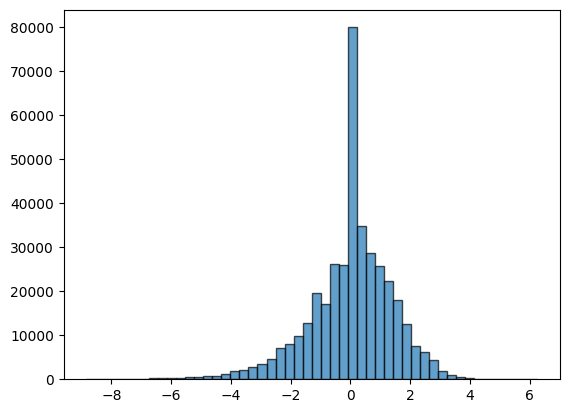

In [ ]:
train_df['rating_centered'].hist(bins=50, edgecolor='black', alpha=0.7, grid=False)
mean = train_df['rating_centered'].mean()
std = train_df['rating_centered'].std()
print(f"Mean: {mean}, Std: {std}")

In [ ]:
# Convert the train DataFrame with centered ratings to a Surprise dataset
data_centered = Dataset.load_from_df(train_df[['user', 'item', 'rating_centered']], reader)

# Split the data into train and test sets
trainset_centered, testset_centered = train_test_split(data_centered, test_size=0.2)

# Train the SVD++ algorithm on the trainset with centered ratings
svdpp_centered = SVDpp(reg_all=0.3)
svdpp_centered.fit(trainset_centered)

# Predict ratings for the testset
predictions_centered = svdpp_centered.test(testset_centered)
test_mae_centered = mae(predictions_centered, verbose=False)

# Calculate and print the MAE for trainset (using cross-validation predictions)
train_predictions_centered = [svdpp_centered.predict(uid, iid, r_ui) for (uid, iid, r_ui) in trainset_centered.build_testset()]
train_mae_centered = mae(train_predictions_centered, verbose=False)

# Print the MAE scores
print(f"Train MAE (Centered): {train_mae_centered}")
print(f"Test MAE (Centered): {test_mae_centered}")

Train MAE (Centered): 1.3217337241327525
Test MAE (Centered): 1.3239418652586876


In [ ]:
# Use the mean rating for each user from the train set
user_mean_map = train_df.set_index('user')['user_mean'].to_dict()
test_df['user_mean'] = test_df['user'].map(user_mean_map)

# Center the ratings by subtracting the user mean rating
test_df['rating_centered'] = test_df['rating'] - test_df['user_mean']

testset = [(row['user'], row['item'], 0) for _, row in test_df.iterrows()]
predictions = svdpp_centered.test(testset)

for i, (uid, iid, true_r, est, _) in enumerate(predictions):
    user_mean = test_df.at[i, 'user_mean'] if not pd.isna(test_df.at[i, 'user_mean']) else 8
    test_df.at[i, 'rating'] = round(est + user_mean)

# Prepare the output file path with a timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_path = f'../out/SVDpp/predicciones_SVD_centered_{timestamp}.csv'

# Export the result to an Excel file
test_df[['ID', 'rating']].to_csv(output_path, index=False)

print(f"File saved to {output_path}")
test_df.sample(10)

File saved to ../out/SVDpp/predicciones_SVD_centered_20250329_205526.csv


,ID,user,item,rating,user_mean,rating_centered
2309,2309,6236,17098,7.0,6.122549,0.877451
22801,22801,4536,1104,10.0,9.448276,-0.448276
8571,8571,5404,15822,11.0,9.571429,-0.571429
10917,10917,4201,12313,10.0,8.856320,0.143680
10122,10122,534,3454,8.0,7.289720,0.710280
9943,9943,2904,6340,11.0,9.750000,-0.750000
8895,8895,9851,14751,8.0,7.416667,0.583333
14570,14570,1613,6687,8.0,7.269841,-0.269841
38061,38061,9842,1373,8.0,6.500000,1.500000
27375,27375,5623,16107,9.0,7.542857,0.457143


<Axes: >

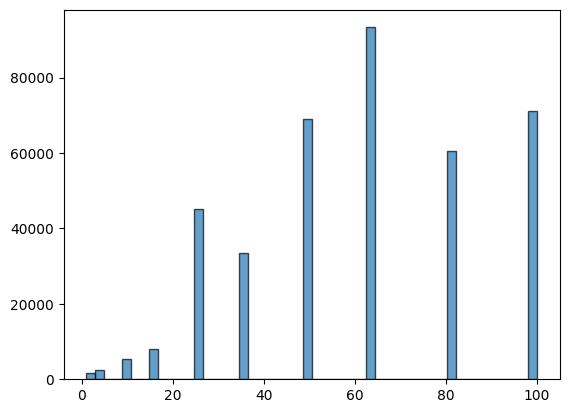

In [ ]:
train_df['rating_squared'] = train_df['rating'] ** 2
train_df[['rating', 'rating_squared']].sample(10)
train_df['rating_squared'].hist(bins=50, edgecolor='black', alpha=0.7, grid=False)

In [ ]:
# Convert the train DataFrame with rating squared to a Surprise dataset
data_squared = Dataset.load_from_df(train_df[['user', 'item', 'rating_squared']], reader)

# Split the data into train and test sets
trainset_squared, testset_squared = train_test_split(data_squared, test_size=0.2)

# Train the SVD++ algorithm on the trainset with rating squared
svdpp_squared = SVDpp(reg_all=0.3)
svdpp_squared.fit(trainset_squared)

# Predict ratings for the testset
predictions_squared = svdpp_squared.test(testset_squared)
test_mae_squared = mae(predictions_squared, verbose=False)

# Calculate and print the MAE for trainset (using cross-validation predictions)
train_predictions_squared = [svdpp_squared.predict(uid, iid, r_ui) for (uid, iid, r_ui) in trainset_squared.build_testset()]
train_mae_squared = mae(train_predictions_squared, verbose=False)

# Print the MAE scores
print(f"Train MAE (Squared): {train_mae_squared}")
print(f"Test MAE (Squared): {test_mae_squared}")

Train MAE (Squared): 51.32584640184988
Test MAE (Squared): 51.45796534162538


In [ ]:
from math import sqrt

testset = [(row['user'], row['item'], 0) for _, row in test_df.iterrows()]
predictions = svdpp_squared.test(testset)

for i, (uid, iid, true_r, est, _) in enumerate(predictions):
    test_df.at[i, 'rating'] = round(sqrt(est))

# Prepare the output file path with a timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_path = f'../out/SVDpp/predicciones_SVD_squared_{timestamp}.csv'

# Export the result to an Excel file
test_df[['ID', 'rating']].to_csv(output_path, index=False)

print(f"File saved to {output_path}")
test_df.sample(10)

File saved to ../out/SVDpp/predicciones_SVD_squared_20250329_205818.csv


,ID,user,item,rating,user_mean,rating_centered
28727,28727,4152,10745,3.0,8.300000,-0.300000
17537,17537,8067,2887,3.0,9.000000,-1.000000
39543,39543,1273,5849,3.0,8.534884,-0.534884
40457,40457,9401,824,3.0,6.800000,0.200000
6070,6070,8841,21672,3.0,6.954839,0.045161
37138,37138,2143,7956,3.0,5.591716,0.408284
10628,10628,8535,2667,3.0,8.318182,-0.318182
8686,8686,8434,21119,3.0,5.200000,1.800000
18668,18668,8076,20733,3.0,8.210863,-0.210863
34249,34249,4082,11883,3.0,2.750000,3.250000


In [ ]:
# Define the parameter grid to search
param_grid = {
    'n_factors': [15, 20, 25, 50],
    'lr_all': [0.005, 0.007, 0.01],
    'reg_all': [0.02, 0.1, 0.3]
}

# Perform grid search
grid_search = GridSearchCV(SVDpp, param_grid, measures=['mae'], cv=3, n_jobs=-1)
grid_search.fit(data)

# Get the best parameters and corresponding MAE
best_params = grid_search.best_params['mae']
best_mae = grid_search.best_score['mae']

print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

c:\Users\alexg\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'n_factors': 15, 'lr_all': 0.007, 'reg_all': 0.1}
Best MAE: 1.2751562593967123


In [ ]:
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
data = Dataset.load_from_df(train_df[['user', 'item', 'rating']], reader)

# Use the best parameters from the grid search to create a new SVD++ instance
best_svdpp = SVDpp(n_factors=best_params['n_factors'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])

# Fit the model using the full trainset
best_svdpp.fit(data.build_full_trainset())

train_predictions = [best_svdpp.predict(uid, iid, r_ui) for (uid, iid, r_ui) in data.build_full_trainset().build_testset()]
train_mae = mae(train_predictions, verbose=False)
print(f"Train MAE (Best SVD++): {train_mae}")

# Prepare the testset
testset = [(row['user'], row['item'], 0) for _, row in test_df.iterrows()]
predictions = best_svdpp.test(testset)

for i, (uid, iid, true_r, est, _) in enumerate(predictions):
    test_df.at[i, 'rating'] = round(est)

# Prepare the output file path with parameters and a timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_path = f"../out/SVDpp/predicciones_SVD_gridsearch_factors_{best_params['n_factors']}_lr_{best_params['lr_all']}_reg_{best_params['reg_all']}_{timestamp}.csv"

# Export the result to a CSV file
test_df[['ID', 'rating']].to_csv(output_path, index=False)

print(f"File saved to {output_path}")
test_df.sample(10)

Train MAE (Best SVD++): 0.9039085753251793
File saved to ../out/SVDpp/predicciones_SVD_gridsearch_factors_15_lr_0.007_reg_0.1_20250330_000204.csv


,ID,user,item,rating,user_mean,rating_centered
6397,6397,5787,12939,9.0,10.000000,-2.000000
5978,5978,3396,2976,8.0,NaN,NaN
10608,10608,3551,10952,7.0,6.600000,0.400000
5704,5704,8841,21685,5.0,6.954839,0.045161
26077,26077,9306,8395,8.0,7.504202,0.495798
14983,14983,3576,2291,8.0,8.750000,-0.750000
38943,38943,2875,9663,7.0,7.741379,0.258621
14533,14533,2477,8779,8.0,7.795455,0.204545
31472,31472,4201,12979,9.0,8.856320,0.143680
1078,1078,9702,23047,7.0,6.000000,1.000000


In [ ]:
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
data = Dataset.load_from_df(train_df[['user', 'item', 'rating']], reader)

# Define the parameter grid to search
param_grid = {
    'n_factors': [4, 6, 8, 10, 12, 15, 20, 30],
    'lr_all': [0.007],
    'reg_all': [0.1]
}

# Perform grid search
grid_search = GridSearchCV(SVDpp, param_grid, measures=['mae'], cv=3, n_jobs=-1)
grid_search.fit(data)

# Get the best parameters and corresponding MAE
best_params = grid_search.best_params['mae']
best_mae = grid_search.best_score['mae']

print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

Best Parameters: {'n_factors': 4, 'lr_all': 0.007, 'reg_all': 0.1}
Best MAE: 1.272171165603339


In [ ]:
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
data = Dataset.load_from_df(train_df[['user', 'item', 'rating']], reader)

# Use the best parameters from the grid search to create a new SVD++ instance
best_svdpp = SVDpp(n_factors=best_params['n_factors'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])

# Fit the model using the full trainset
best_svdpp.fit(data.build_full_trainset())

train_predictions = [best_svdpp.predict(uid, iid, r_ui) for (uid, iid, r_ui) in data.build_full_trainset().build_testset()]
train_mae = mae(train_predictions, verbose=False)
print(f"Train MAE (Best SVD++): {train_mae}")

# Prepare the testset
testset = [(row['user'], row['item'], 0) for _, row in test_df.iterrows()]
predictions = best_svdpp.test(testset)

for i, (uid, iid, true_r, est, _) in enumerate(predictions):
    test_df.at[i, 'rating'] = round(est)

# Prepare the output file path with parameters and a timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_path = f"../out/SVDpp/predicciones_SVDpp_gridsearch_factors_{best_params['n_factors']}_lr_{best_params['lr_all']}_reg_{best_params['reg_all']}_{timestamp}.csv"

# Export the result to a CSV file
test_df[['ID', 'rating']].to_csv(output_path, index=False)

print(f"File saved to {output_path}")
test_df.sample(10)

Train MAE (Best SVD++): 1.001909943398906
File saved to ../out/SVDpp/predicciones_SVDpp_gridsearch_factors_4_lr_0.007_reg_0.1_20250330_140004.csv


,ID,user,item,rating
34116,34116,8256,20944,7.0
5015,5015,8691,21463,8.0
21863,21863,6645,17710,7.0
5544,5544,11195,18130,8.0
13323,13323,9722,5713,7.0
2849,2849,534,1796,7.0
20199,20199,5535,15986,7.0
40174,40174,752,4237,7.0
10635,10635,1495,3813,8.0
32999,32999,4096,11911,7.0


In [ ]:
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
data = Dataset.load_from_df(train_df[['user', 'item', 'rating']], reader)

# Define the parameter grid to search
param_grid = {
    'n_factors': [4, 6, 8, 10, 12, 15, 20, 30],
    'lr_all': [0.007],
    'reg_all': [0.3]
}

# Perform grid search
grid_search = GridSearchCV(SVDpp, param_grid, measures=['mae'], cv=3, n_jobs=-1)
grid_search.fit(data)

# Get the best parameters and corresponding MAE
best_params = grid_search.best_params['mae']
best_mae = grid_search.best_score['mae']

print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

c:\Users\alexg\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'n_factors': 4, 'lr_all': 0.007, 'reg_all': 0.3}
Best MAE: 1.2854556600887084


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Cargar los datos
df_train = pd.read_csv("../data/train.csv")

# Configuración del lector para Surprise
reader = Reader(rating_scale=(df_train['rating'].min(), df_train['rating'].max()))
data = Dataset.load_from_df(df_train[['user', 'item', 'rating']], reader)

# Definir la función de objetivo para Optuna
def objective(trial):
    try:
        # Hiperparámetros básicos
        n_factors = trial.suggest_int('n_factors', 10, 50)
        n_epochs = trial.suggest_int('n_epochs', 10, 50)
        init_mean = trial.suggest_uniform('init_mean', -0.05, 0.05)
        init_std_dev = trial.suggest_uniform('init_std_dev', 0.01, 0.1)
        lr_all = trial.suggest_loguniform('lr_all', 1e-4, 1e-2)
        reg_all = trial.suggest_loguniform('reg_all', 1e-4, 0.1)

        # Parámetros específicos de aprendizaje
        lr_bu = trial.suggest_loguniform('lr_bu', 1e-4, 1e-2)
        lr_bi = trial.suggest_loguniform('lr_bi', 1e-4, 1e-2)
        lr_pu = trial.suggest_loguniform('lr_pu', 1e-4, 1e-2)
        lr_qi = trial.suggest_loguniform('lr_qi', 1e-4, 1e-2)
        lr_yj = trial.suggest_loguniform('lr_yj', 1e-4, 1e-2)

        # Parámetros específicos de regularización
        reg_bu = trial.suggest_loguniform('reg_bu', 1e-4, 0.1)
        reg_bi = trial.suggest_loguniform('reg_bi', 1e-4, 0.1)
        reg_pu = trial.suggest_loguniform('reg_pu', 1e-4, 0.1)
        reg_qi = trial.suggest_loguniform('reg_qi', 1e-4, 0.1)
        reg_yj = trial.suggest_loguniform('reg_yj', 1e-4, 0.1)

        # Crear el modelo SVD++
        algo = SVDpp(
            n_factors=n_factors,
            n_epochs=n_epochs,
            init_mean=init_mean,
            init_std_dev=init_std_dev,
            lr_all=lr_all,
            reg_all=reg_all,
            lr_bu=lr_bu,
            lr_bi=lr_bi,
            lr_pu=lr_pu,
            lr_qi=lr_qi,
            lr_yj=lr_yj,
            reg_bu=reg_bu,
            reg_bi=reg_bi,
            reg_pu=reg_pu,
            reg_qi=reg_qi,
            reg_yj=reg_yj,
            verbose=False
        )

        # Validación cruzada usando 3 particiones con loky backend
        with parallel_backend("loky"):
            cv_results = cross_validate(algo, data, measures=['mae'], cv=3, verbose=False, n_jobs=14)

        # Calcular el MAE promedio de las validaciones cruzadas
        mae = sum(cv_results['test_mae']) / len(cv_results['test_mae'])
        print(f"Resultado MAE: {mae} ; Probando parámetros: n_factors={n_factors}, n_epochs={n_epochs}, init_mean={init_mean}, init_std_dev={init_std_dev}, "
              f"lr_all={lr_all}, reg_all={reg_all}, lr_bu={lr_bu}, lr_bi={lr_bi}, lr_pu={lr_pu}, lr_qi={lr_qi}, lr_yj={lr_yj}, "
              f"reg_bu={reg_bu}, reg_bi={reg_bi}, reg_pu={reg_pu}, reg_qi={reg_qi}, reg_yj={reg_yj}")
        return mae
    except Exception as e:
        print(f"Error en la evaluación con parámetros: {e}")
        return float('inf')

# Crear un estudio de optimización con loky
print("Iniciando la optimización de hiperparámetros con Optuna usando loky...")
study = optuna.create_study(direction="minimize")
with parallel_backend("loky"):
    study.optimize(objective, n_trials=75, n_jobs=1)

# Obtener los mejores hiperparámetros
best_params = study.best_params
best_mae = study.best_value

print(f"Mejores parámetros encontrados: {best_params}")
print(f"Mejor MAE: {best_mae}")

# Entrenar el modelo final con los mejores parámetros
print("Entrenando el modelo final con los mejores hiperparámetros...")
best_model = SVDpp(
    n_factors=best_params['n_factors'],
    n_epochs=best_params['n_epochs'],
    init_mean=best_params['init_mean'],
    init_std_dev=best_params['init_std_dev'],
    lr_all=best_params['lr_all'],
    reg_all=best_params['reg_all'],
    lr_bu=best_params['lr_bu'],
    lr_bi=best_params['lr_bi'],
    lr_pu=best_params['lr_pu'],
    lr_qi=best_params['lr_qi'],
    lr_yj=best_params['lr_yj'],
    reg_bu=best_params['reg_bu'],
    reg_bi=best_params['reg_bi'],
    reg_pu=best_params['reg_pu'],
    reg_qi=best_params['reg_qi'],
    reg_yj=best_params['reg_yj'],
    verbose=True
)
trainset = data.build_full_trainset()
best_model.fit(trainset)

print("Entrenamiento final completado.")

[I 2025-03-30 19:49:38,830] A new study created in memory with name: no-name-a4db9748-8666-4825-81ff-1db1f4b50ab8


Iniciando la optimización de hiperparámetros con Optuna usando loky...


[I 2025-03-30 19:53:06,338] Trial 0 finished with value: 1.2755801691413742 and parameters: {'n_factors': 29, 'n_epochs': 49, 'init_mean': -0.027371684047993484, 'init_std_dev': 0.030719581612553087, 'lr_all': 0.00010522780708410899, 'reg_all': 0.0007401546962041615, 'lr_bu': 0.002422183635363356, 'lr_bi': 0.002433906648448587, 'lr_pu': 0.0003352122813841975, 'lr_qi': 0.00019994777451708321, 'lr_yj': 0.00023763494195863752, 'reg_bu': 0.002415306754951884, 'reg_bi': 0.00012819386872805225, 'reg_pu': 0.006263820109774725, 'reg_qi': 0.06108358175458227, 'reg_yj': 0.01697534974993703}. Best is trial 0 with value: 1.2755801691413742.


Resultado MAE: 1.2755801691413742 ; Probando parámetros: n_factors=29, n_epochs=49, init_mean=-0.027371684047993484, init_std_dev=0.030719581612553087, lr_all=0.00010522780708410899, reg_all=0.0007401546962041615, lr_bu=0.002422183635363356, lr_bi=0.002433906648448587, lr_pu=0.0003352122813841975, lr_qi=0.00019994777451708321, lr_yj=0.00023763494195863752, reg_bu=0.002415306754951884, reg_bi=0.00012819386872805225, reg_pu=0.006263820109774725, reg_qi=0.06108358175458227, reg_yj=0.01697534974993703


[I 2025-03-30 19:54:52,354] Trial 1 finished with value: 1.321015462130668 and parameters: {'n_factors': 32, 'n_epochs': 24, 'init_mean': 0.04015924691042508, 'init_std_dev': 0.0929044066798596, 'lr_all': 0.00125582225161443, 'reg_all': 0.011565939876985334, 'lr_bu': 0.009277543069909513, 'lr_bi': 0.0022379752850849783, 'lr_pu': 0.0028850217451881067, 'lr_qi': 0.0007450124297431495, 'lr_yj': 0.0025672448944226525, 'reg_bu': 0.0003888231516324992, 'reg_bi': 0.00024670143741500623, 'reg_pu': 0.0005082503480948078, 'reg_qi': 0.0020030269956158803, 'reg_yj': 0.00013435909828915065}. Best is trial 0 with value: 1.2755801691413742.


Resultado MAE: 1.321015462130668 ; Probando parámetros: n_factors=32, n_epochs=24, init_mean=0.04015924691042508, init_std_dev=0.0929044066798596, lr_all=0.00125582225161443, reg_all=0.011565939876985334, lr_bu=0.009277543069909513, lr_bi=0.0022379752850849783, lr_pu=0.0028850217451881067, lr_qi=0.0007450124297431495, lr_yj=0.0025672448944226525, reg_bu=0.0003888231516324992, reg_bi=0.00024670143741500623, reg_pu=0.0005082503480948078, reg_qi=0.0020030269956158803, reg_yj=0.00013435909828915065


[I 2025-03-30 19:57:04,457] Trial 2 finished with value: 1.3417437308271971 and parameters: {'n_factors': 20, 'n_epochs': 49, 'init_mean': 0.030975797403582986, 'init_std_dev': 0.09681136882394303, 'lr_all': 0.0002653804630181882, 'reg_all': 0.011672683946381648, 'lr_bu': 0.00043986964249559943, 'lr_bi': 0.005235859316839693, 'lr_pu': 0.003676773731096517, 'lr_qi': 0.0010091196821261235, 'lr_yj': 0.005549921819063834, 'reg_bu': 0.0002559703698519941, 'reg_bi': 0.0013411357676955359, 'reg_pu': 0.05527225221730604, 'reg_qi': 0.04239430752010864, 'reg_yj': 0.009519478632669422}. Best is trial 0 with value: 1.2755801691413742.


Resultado MAE: 1.3417437308271971 ; Probando parámetros: n_factors=20, n_epochs=49, init_mean=0.030975797403582986, init_std_dev=0.09681136882394303, lr_all=0.0002653804630181882, reg_all=0.011672683946381648, lr_bu=0.00043986964249559943, lr_bi=0.005235859316839693, lr_pu=0.003676773731096517, lr_qi=0.0010091196821261235, lr_yj=0.005549921819063834, reg_bu=0.0002559703698519941, reg_bi=0.0013411357676955359, reg_pu=0.05527225221730604, reg_qi=0.04239430752010864, reg_yj=0.009519478632669422


[I 2025-03-30 19:57:59,274] Trial 3 finished with value: 1.3977310894760855 and parameters: {'n_factors': 29, 'n_epochs': 13, 'init_mean': 0.04400805307222798, 'init_std_dev': 0.021108552608554557, 'lr_all': 0.00028653937847458635, 'reg_all': 0.00021431757349678633, 'lr_bu': 0.00011603832910324767, 'lr_bi': 0.004515782783024316, 'lr_pu': 0.0035174204134133017, 'lr_qi': 0.00017310992782690757, 'lr_yj': 0.0044066993537622235, 'reg_bu': 0.0004825397199929988, 'reg_bi': 0.005647283366499577, 'reg_pu': 0.0008243403132961646, 'reg_qi': 0.004116157462926566, 'reg_yj': 0.004314990342224982}. Best is trial 0 with value: 1.2755801691413742.


Resultado MAE: 1.3977310894760855 ; Probando parámetros: n_factors=29, n_epochs=13, init_mean=0.04400805307222798, init_std_dev=0.021108552608554557, lr_all=0.00028653937847458635, reg_all=0.00021431757349678633, lr_bu=0.00011603832910324767, lr_bi=0.004515782783024316, lr_pu=0.0035174204134133017, lr_qi=0.00017310992782690757, lr_yj=0.0044066993537622235, reg_bu=0.0004825397199929988, reg_bi=0.005647283366499577, reg_pu=0.0008243403132961646, reg_qi=0.004116157462926566, reg_yj=0.004314990342224982


[I 2025-03-30 20:01:20,067] Trial 4 finished with value: 1.4120611182110487 and parameters: {'n_factors': 42, 'n_epochs': 34, 'init_mean': -0.01562432313687069, 'init_std_dev': 0.06529833707207068, 'lr_all': 0.0005422344589731538, 'reg_all': 0.0005464007428209711, 'lr_bu': 0.00013589610365933756, 'lr_bi': 0.00023205980167157855, 'lr_pu': 0.00021737635095855866, 'lr_qi': 0.0053611189402976555, 'lr_yj': 0.00017540157322192855, 'reg_bu': 0.06541908279884576, 'reg_bi': 0.0019230111833301719, 'reg_pu': 0.0035078494767681874, 'reg_qi': 0.0001324851929720041, 'reg_yj': 0.001087416538296126}. Best is trial 0 with value: 1.2755801691413742.


Resultado MAE: 1.4120611182110487 ; Probando parámetros: n_factors=42, n_epochs=34, init_mean=-0.01562432313687069, init_std_dev=0.06529833707207068, lr_all=0.0005422344589731538, reg_all=0.0005464007428209711, lr_bu=0.00013589610365933756, lr_bi=0.00023205980167157855, lr_pu=0.00021737635095855866, lr_qi=0.0053611189402976555, lr_yj=0.00017540157322192855, reg_bu=0.06541908279884576, reg_bi=0.0019230111833301719, reg_pu=0.0035078494767681874, reg_qi=0.0001324851929720041, reg_yj=0.001087416538296126


[I 2025-03-30 20:02:41,646] Trial 5 finished with value: 1.3943163509794172 and parameters: {'n_factors': 38, 'n_epochs': 14, 'init_mean': -0.011700694301737834, 'init_std_dev': 0.09615567447615198, 'lr_all': 0.004122928877615288, 'reg_all': 0.019770483158055355, 'lr_bu': 0.00022971373854298451, 'lr_bi': 0.005250021798303312, 'lr_pu': 0.004738505371608561, 'lr_qi': 0.0012884328742307674, 'lr_yj': 0.0033295795150774586, 'reg_bu': 0.04289043067629278, 'reg_bi': 0.00010634916436289217, 'reg_pu': 0.0030950664973801736, 'reg_qi': 0.00011304012235158511, 'reg_yj': 0.0001615916051040345}. Best is trial 0 with value: 1.2755801691413742.


Resultado MAE: 1.3943163509794172 ; Probando parámetros: n_factors=38, n_epochs=14, init_mean=-0.011700694301737834, init_std_dev=0.09615567447615198, lr_all=0.004122928877615288, reg_all=0.019770483158055355, lr_bu=0.00022971373854298451, lr_bi=0.005250021798303312, lr_pu=0.004738505371608561, lr_qi=0.0012884328742307674, lr_yj=0.0033295795150774586, reg_bu=0.04289043067629278, reg_bi=0.00010634916436289217, reg_pu=0.0030950664973801736, reg_qi=0.00011304012235158511, reg_yj=0.0001615916051040345


[I 2025-03-30 20:04:23,793] Trial 6 finished with value: 1.2834856888387705 and parameters: {'n_factors': 14, 'n_epochs': 41, 'init_mean': -0.028455129414985604, 'init_std_dev': 0.03204546955717767, 'lr_all': 0.00025861331753323114, 'reg_all': 0.006489101691982149, 'lr_bu': 0.002842275637058869, 'lr_bi': 0.008601112566086927, 'lr_pu': 0.005989473422775997, 'lr_qi': 0.0006048493066651875, 'lr_yj': 0.007980098493511004, 'reg_bu': 0.00778388016740259, 'reg_bi': 0.0026439342955678073, 'reg_pu': 0.06146599763781726, 'reg_qi': 0.0004891337929235592, 'reg_yj': 0.013161430183516544}. Best is trial 0 with value: 1.2755801691413742.


Resultado MAE: 1.2834856888387705 ; Probando parámetros: n_factors=14, n_epochs=41, init_mean=-0.028455129414985604, init_std_dev=0.03204546955717767, lr_all=0.00025861331753323114, reg_all=0.006489101691982149, lr_bu=0.002842275637058869, lr_bi=0.008601112566086927, lr_pu=0.005989473422775997, lr_qi=0.0006048493066651875, lr_yj=0.007980098493511004, reg_bu=0.00778388016740259, reg_bi=0.0026439342955678073, reg_pu=0.06146599763781726, reg_qi=0.0004891337929235592, reg_yj=0.013161430183516544


[I 2025-03-30 20:06:04,986] Trial 7 finished with value: 1.3576792696393536 and parameters: {'n_factors': 13, 'n_epochs': 41, 'init_mean': -0.03845181590490691, 'init_std_dev': 0.06658491474021327, 'lr_all': 0.000146465509058939, 'reg_all': 0.0015344882301194767, 'lr_bu': 0.00034090841529188916, 'lr_bi': 0.007727679036986633, 'lr_pu': 0.002272886203476633, 'lr_qi': 0.0010160017269628824, 'lr_yj': 0.0006022413083771849, 'reg_bu': 0.0015386488786566165, 'reg_bi': 0.0002974098383610344, 'reg_pu': 0.006929384512300827, 'reg_qi': 0.006680969462252455, 'reg_yj': 0.017438854341893163}. Best is trial 0 with value: 1.2755801691413742.


Resultado MAE: 1.3576792696393536 ; Probando parámetros: n_factors=13, n_epochs=41, init_mean=-0.03845181590490691, init_std_dev=0.06658491474021327, lr_all=0.000146465509058939, reg_all=0.0015344882301194767, lr_bu=0.00034090841529188916, lr_bi=0.007727679036986633, lr_pu=0.002272886203476633, lr_qi=0.0010160017269628824, lr_yj=0.0006022413083771849, reg_bu=0.0015386488786566165, reg_bi=0.0002974098383610344, reg_pu=0.006929384512300827, reg_qi=0.006680969462252455, reg_yj=0.017438854341893163


[I 2025-03-30 20:07:48,616] Trial 8 finished with value: 1.3548511844193225 and parameters: {'n_factors': 18, 'n_epochs': 39, 'init_mean': 0.03783213404837024, 'init_std_dev': 0.05721685512793886, 'lr_all': 0.0018865839335151266, 'reg_all': 0.0007017360810233281, 'lr_bu': 0.0007934571537118262, 'lr_bi': 0.0004904933493648015, 'lr_pu': 0.00868463394966615, 'lr_qi': 0.00244368196821912, 'lr_yj': 0.00023552958916092082, 'reg_bu': 0.01825452988143969, 'reg_bi': 0.021735558953599743, 'reg_pu': 0.0006129280281911182, 'reg_qi': 0.00017696429723681719, 'reg_yj': 0.0036951789943048853}. Best is trial 0 with value: 1.2755801691413742.


Resultado MAE: 1.3548511844193225 ; Probando parámetros: n_factors=18, n_epochs=39, init_mean=0.03783213404837024, init_std_dev=0.05721685512793886, lr_all=0.0018865839335151266, reg_all=0.0007017360810233281, lr_bu=0.0007934571537118262, lr_bi=0.0004904933493648015, lr_pu=0.00868463394966615, lr_qi=0.00244368196821912, lr_yj=0.00023552958916092082, reg_bu=0.01825452988143969, reg_bi=0.021735558953599743, reg_pu=0.0006129280281911182, reg_qi=0.00017696429723681719, reg_yj=0.0036951789943048853


[I 2025-03-30 20:09:41,880] Trial 9 finished with value: 1.3310528832531572 and parameters: {'n_factors': 18, 'n_epochs': 41, 'init_mean': 0.039761255252265634, 'init_std_dev': 0.03972918963286734, 'lr_all': 0.0012668001268794698, 'reg_all': 0.0013874988620525578, 'lr_bu': 0.0005373339560370221, 'lr_bi': 0.00042030307513073547, 'lr_pu': 0.00023303419018598203, 'lr_qi': 0.0005861345033295447, 'lr_yj': 0.00010442499403541549, 'reg_bu': 0.002555991531298631, 'reg_bi': 0.0011994159721996588, 'reg_pu': 0.00011464213342783298, 'reg_qi': 0.011891597244473162, 'reg_yj': 0.08816138064956351}. Best is trial 0 with value: 1.2755801691413742.


Resultado MAE: 1.3310528832531572 ; Probando parámetros: n_factors=18, n_epochs=41, init_mean=0.039761255252265634, init_std_dev=0.03972918963286734, lr_all=0.0012668001268794698, reg_all=0.0013874988620525578, lr_bu=0.0005373339560370221, lr_bi=0.00042030307513073547, lr_pu=0.00023303419018598203, lr_qi=0.0005861345033295447, lr_yj=0.00010442499403541549, reg_bu=0.002555991531298631, reg_bi=0.0011994159721996588, reg_pu=0.00011464213342783298, reg_qi=0.011891597244473162, reg_yj=0.08816138064956351


[I 2025-03-30 20:15:49,947] Trial 10 finished with value: 1.2636034084316825 and parameters: {'n_factors': 47, 'n_epochs': 50, 'init_mean': 0.013264486324042507, 'init_std_dev': 0.01188328641958163, 'lr_all': 0.00010486245568457871, 'reg_all': 0.07867121726419232, 'lr_bu': 0.0022971422916090653, 'lr_bi': 0.0014376064788556163, 'lr_pu': 0.0006153828911076795, 'lr_qi': 0.00010301609112770345, 'lr_yj': 0.0006134198104453135, 'reg_bu': 0.00012586384001361372, 'reg_bi': 0.05932577924391447, 'reg_pu': 0.01570018160943211, 'reg_qi': 0.0857494657885554, 'reg_yj': 0.09861170768675968}. Best is trial 10 with value: 1.2636034084316825.


Resultado MAE: 1.2636034084316825 ; Probando parámetros: n_factors=47, n_epochs=50, init_mean=0.013264486324042507, init_std_dev=0.01188328641958163, lr_all=0.00010486245568457871, reg_all=0.07867121726419232, lr_bu=0.0022971422916090653, lr_bi=0.0014376064788556163, lr_pu=0.0006153828911076795, lr_qi=0.00010301609112770345, lr_yj=0.0006134198104453135, reg_bu=0.00012586384001361372, reg_bi=0.05932577924391447, reg_pu=0.01570018160943211, reg_qi=0.0857494657885554, reg_yj=0.09861170768675968


[I 2025-03-30 20:21:46,671] Trial 11 finished with value: 1.2647585005016615 and parameters: {'n_factors': 46, 'n_epochs': 50, 'init_mean': 0.014250620213017956, 'init_std_dev': 0.010590905475254942, 'lr_all': 0.00010527865490755384, 'reg_all': 0.046327143910464906, 'lr_bu': 0.002230777825028948, 'lr_bi': 0.001349108315021646, 'lr_pu': 0.0007235905817615714, 'lr_qi': 0.00010101603182986151, 'lr_yj': 0.0006617960200592504, 'reg_bu': 0.00010019595320429986, 'reg_bi': 0.09678857213850885, 'reg_pu': 0.011815688399412601, 'reg_qi': 0.07859280294900214, 'reg_yj': 0.07860820456321531}. Best is trial 10 with value: 1.2636034084316825.


Resultado MAE: 1.2647585005016615 ; Probando parámetros: n_factors=46, n_epochs=50, init_mean=0.014250620213017956, init_std_dev=0.010590905475254942, lr_all=0.00010527865490755384, reg_all=0.046327143910464906, lr_bu=0.002230777825028948, lr_bi=0.001349108315021646, lr_pu=0.0007235905817615714, lr_qi=0.00010101603182986151, lr_yj=0.0006617960200592504, reg_bu=0.00010019595320429986, reg_bi=0.09678857213850885, reg_pu=0.011815688399412601, reg_qi=0.07859280294900214, reg_yj=0.07860820456321531


[I 2025-03-30 20:28:01,064] Trial 12 finished with value: 1.2676027641539314 and parameters: {'n_factors': 50, 'n_epochs': 50, 'init_mean': 0.01620724411836474, 'init_std_dev': 0.01666813907623197, 'lr_all': 0.009415127204077257, 'reg_all': 0.08930760682444311, 'lr_bu': 0.0020076427620692307, 'lr_bi': 0.0013307572577882683, 'lr_pu': 0.0007713656469193922, 'lr_qi': 0.0001082554911673867, 'lr_yj': 0.0009020560605030834, 'reg_bu': 0.00010379157880335083, 'reg_bi': 0.09491290909432512, 'reg_pu': 0.021315257604816087, 'reg_qi': 0.09108845186363441, 'reg_yj': 0.0955673280026544}. Best is trial 10 with value: 1.2636034084316825.


Resultado MAE: 1.2676027641539314 ; Probando parámetros: n_factors=50, n_epochs=50, init_mean=0.01620724411836474, init_std_dev=0.01666813907623197, lr_all=0.009415127204077257, reg_all=0.08930760682444311, lr_bu=0.0020076427620692307, lr_bi=0.0013307572577882683, lr_pu=0.0007713656469193922, lr_qi=0.0001082554911673867, lr_yj=0.0009020560605030834, reg_bu=0.00010379157880335083, reg_bi=0.09491290909432512, reg_pu=0.021315257604816087, reg_qi=0.09108845186363441, reg_yj=0.0955673280026544


[I 2025-03-30 20:31:22,390] Trial 13 finished with value: 1.2658001505912804 and parameters: {'n_factors': 49, 'n_epochs': 24, 'init_mean': 0.011461204372211951, 'init_std_dev': 0.010861981867840525, 'lr_all': 0.00010290336610794867, 'reg_all': 0.09630594056565109, 'lr_bu': 0.006190010128720809, 'lr_bi': 0.000942626216825588, 'lr_pu': 0.0007028021530215566, 'lr_qi': 0.00029508461083190365, 'lr_yj': 0.0005274412523915668, 'reg_bu': 0.00010550810752056581, 'reg_bi': 0.07715224209492447, 'reg_pu': 0.01792370478871744, 'reg_qi': 0.020718994070480907, 'reg_yj': 0.049280141683504614}. Best is trial 10 with value: 1.2636034084316825.


Resultado MAE: 1.2658001505912804 ; Probando parámetros: n_factors=49, n_epochs=24, init_mean=0.011461204372211951, init_std_dev=0.010861981867840525, lr_all=0.00010290336610794867, reg_all=0.09630594056565109, lr_bu=0.006190010128720809, lr_bi=0.000942626216825588, lr_pu=0.0007028021530215566, lr_qi=0.00029508461083190365, lr_yj=0.0005274412523915668, reg_bu=0.00010550810752056581, reg_bi=0.07715224209492447, reg_pu=0.01792370478871744, reg_qi=0.020718994070480907, reg_yj=0.049280141683504614


[I 2025-03-30 20:35:47,288] Trial 14 finished with value: 1.2910772174452945 and parameters: {'n_factors': 43, 'n_epochs': 45, 'init_mean': 0.008344289200288443, 'init_std_dev': 0.043651288469989974, 'lr_all': 0.0006162317034658314, 'reg_all': 0.03563748767439932, 'lr_bu': 0.0015355689902377982, 'lr_bi': 0.00010028670410824198, 'lr_pu': 0.001607072235587411, 'lr_qi': 0.00011852580153678612, 'lr_yj': 0.0017198244246872604, 'reg_bu': 0.0007425157008412277, 'reg_bi': 0.024061731779339006, 'reg_pu': 0.019300730452874584, 'reg_qi': 0.023432827562089836, 'reg_yj': 0.03269898363406936}. Best is trial 10 with value: 1.2636034084316825.


Resultado MAE: 1.2910772174452945 ; Probando parámetros: n_factors=43, n_epochs=45, init_mean=0.008344289200288443, init_std_dev=0.043651288469989974, lr_all=0.0006162317034658314, reg_all=0.03563748767439932, lr_bu=0.0015355689902377982, lr_bi=0.00010028670410824198, lr_pu=0.001607072235587411, lr_qi=0.00011852580153678612, lr_yj=0.0017198244246872604, reg_bu=0.0007425157008412277, reg_bi=0.024061731779339006, reg_pu=0.019300730452874584, reg_qi=0.023432827562089836, reg_yj=0.03269898363406936


[I 2025-03-30 20:38:42,284] Trial 15 finished with value: 1.2827254095827916 and parameters: {'n_factors': 44, 'n_epochs': 32, 'init_mean': 0.021604504168950513, 'init_std_dev': 0.021867438309302756, 'lr_all': 0.00017363549886929353, 'reg_all': 0.03699939442637235, 'lr_bu': 0.004217461910256659, 'lr_bi': 0.0010751772304487693, 'lr_pu': 0.00010440476587727115, 'lr_qi': 0.000313716938316252, 'lr_yj': 0.0013540314318191526, 'reg_bu': 0.00016105281279159286, 'reg_bi': 0.027071471394641552, 'reg_pu': 0.009088010015332762, 'reg_qi': 0.001373674774393936, 'reg_yj': 0.0008201344850388047}. Best is trial 10 with value: 1.2636034084316825.


Resultado MAE: 1.2827254095827916 ; Probando parámetros: n_factors=44, n_epochs=32, init_mean=0.021604504168950513, init_std_dev=0.021867438309302756, lr_all=0.00017363549886929353, reg_all=0.03699939442637235, lr_bu=0.004217461910256659, lr_bi=0.0010751772304487693, lr_pu=0.00010440476587727115, lr_qi=0.000313716938316252, lr_yj=0.0013540314318191526, reg_bu=0.00016105281279159286, reg_bi=0.027071471394641552, reg_pu=0.009088010015332762, reg_qi=0.001373674774393936, reg_yj=0.0008201344850388047


[I 2025-03-30 20:41:07,885] Trial 16 finished with value: 1.2969697705248964 and parameters: {'n_factors': 36, 'n_epochs': 26, 'init_mean': -0.0022259365432360976, 'init_std_dev': 0.03001301532127764, 'lr_all': 0.0005095125884396033, 'reg_all': 0.004049430208523835, 'lr_bu': 0.0013965348951509799, 'lr_bi': 0.002242737510745223, 'lr_pu': 0.0004952766382897794, 'lr_qi': 0.00875668068743206, 'lr_yj': 0.0008550697584448015, 'reg_bu': 0.000873572315343957, 'reg_bi': 0.008599932221450479, 'reg_pu': 0.09207384715462014, 'reg_qi': 0.028201867460054254, 'reg_yj': 0.040324693672911305}. Best is trial 10 with value: 1.2636034084316825.


Resultado MAE: 1.2969697705248964 ; Probando parámetros: n_factors=36, n_epochs=26, init_mean=-0.0022259365432360976, init_std_dev=0.03001301532127764, lr_all=0.0005095125884396033, reg_all=0.004049430208523835, lr_bu=0.0013965348951509799, lr_bi=0.002242737510745223, lr_pu=0.0004952766382897794, lr_qi=0.00875668068743206, lr_yj=0.0008550697584448015, reg_bu=0.000873572315343957, reg_bi=0.008599932221450479, reg_pu=0.09207384715462014, reg_qi=0.028201867460054254, reg_yj=0.040324693672911305


[I 2025-03-30 20:45:19,086] Trial 17 finished with value: 1.267744154189926 and parameters: {'n_factors': 48, 'n_epochs': 36, 'init_mean': 0.00047428276980755036, 'init_std_dev': 0.07867054829328571, 'lr_all': 0.00018171299737068113, 'reg_all': 0.04089154491168524, 'lr_bu': 0.0040620074320345265, 'lr_bi': 0.0005558906283436449, 'lr_pu': 0.0012554141260775183, 'lr_qi': 0.0003458297822844001, 'lr_yj': 0.0004035432038739244, 'reg_bu': 0.00024681758580827605, 'reg_bi': 0.045655054996984516, 'reg_pu': 0.0012342909440533141, 'reg_qi': 0.09910262190115157, 'reg_yj': 0.0010216142086824412}. Best is trial 10 with value: 1.2636034084316825.


Resultado MAE: 1.267744154189926 ; Probando parámetros: n_factors=48, n_epochs=36, init_mean=0.00047428276980755036, init_std_dev=0.07867054829328571, lr_all=0.00018171299737068113, reg_all=0.04089154491168524, lr_bu=0.0040620074320345265, lr_bi=0.0005558906283436449, lr_pu=0.0012554141260775183, lr_qi=0.0003458297822844001, lr_yj=0.0004035432038739244, reg_bu=0.00024681758580827605, reg_bi=0.045655054996984516, reg_pu=0.0012342909440533141, reg_qi=0.09910262190115157, reg_yj=0.0010216142086824412


[I 2025-03-30 20:48:47,619] Trial 18 finished with value: 1.3058893262532083 and parameters: {'n_factors': 39, 'n_epochs': 46, 'init_mean': 0.02651966126115103, 'init_std_dev': 0.04737499997475232, 'lr_all': 0.00040265802665657746, 'reg_all': 0.06176659073289776, 'lr_bu': 0.0009492191445535456, 'lr_bi': 0.001604410169483144, 'lr_pu': 0.0004555041201146675, 'lr_qi': 0.00010141706506657398, 'lr_yj': 0.0003657703851858381, 'reg_bu': 0.007935473091378795, 'reg_bi': 0.011554937921827673, 'reg_pu': 0.02796577105040835, 'reg_qi': 0.009090832827355046, 'reg_yj': 0.007341321889039196}. Best is trial 10 with value: 1.2636034084316825.


Resultado MAE: 1.3058893262532083 ; Probando parámetros: n_factors=39, n_epochs=46, init_mean=0.02651966126115103, init_std_dev=0.04737499997475232, lr_all=0.00040265802665657746, reg_all=0.06176659073289776, lr_bu=0.0009492191445535456, lr_bi=0.001604410169483144, lr_pu=0.0004555041201146675, lr_qi=0.00010141706506657398, lr_yj=0.0003657703851858381, reg_bu=0.007935473091378795, reg_bi=0.011554937921827673, reg_pu=0.02796577105040835, reg_qi=0.009090832827355046, reg_yj=0.007341321889039196


[I 2025-03-30 20:50:10,269] Trial 19 finished with value: 1.2842428529272272 and parameters: {'n_factors': 34, 'n_epochs': 19, 'init_mean': 0.0019015492800174387, 'init_std_dev': 0.01141429437450174, 'lr_all': 0.0023331703345020973, 'reg_all': 0.017648439374010005, 'lr_bu': 0.0035002266773193156, 'lr_bi': 0.0007682373892372219, 'lr_pu': 0.0011034562964084408, 'lr_qi': 0.00018858442173788498, 'lr_yj': 0.0020843879447473273, 'reg_bu': 0.0010563377227375162, 'reg_bi': 0.052577635704371004, 'reg_pu': 0.0031246173733963166, 'reg_qi': 0.043117890604870764, 'reg_yj': 0.035022018049797696}. Best is trial 10 with value: 1.2636034084316825.


Resultado MAE: 1.2842428529272272 ; Probando parámetros: n_factors=34, n_epochs=19, init_mean=0.0019015492800174387, init_std_dev=0.01141429437450174, lr_all=0.0023331703345020973, reg_all=0.017648439374010005, lr_bu=0.0035002266773193156, lr_bi=0.0007682373892372219, lr_pu=0.0011034562964084408, lr_qi=0.00018858442173788498, lr_yj=0.0020843879447473273, reg_bu=0.0010563377227375162, reg_bi=0.052577635704371004, reg_pu=0.0031246173733963166, reg_qi=0.043117890604870764, reg_yj=0.035022018049797696


[I 2025-03-30 20:52:40,903] Trial 20 finished with value: 1.376100102956501 and parameters: {'n_factors': 26, 'n_epochs': 45, 'init_mean': -0.048658555284474415, 'init_std_dev': 0.024563376632051596, 'lr_all': 0.0008710807919852652, 'reg_all': 0.005839788936261139, 'lr_bu': 0.0013582852234451746, 'lr_bi': 0.0002527207398915068, 'lr_pu': 0.00010893949936100847, 'lr_qi': 0.0018305674939540241, 'lr_yj': 0.0011222977290621444, 'reg_bu': 0.00020754103973453706, 'reg_bi': 0.01706797888457585, 'reg_pu': 0.011416164079687893, 'reg_qi': 0.0007953349849471825, 'reg_yj': 0.000342412833458707}. Best is trial 10 with value: 1.2636034084316825.


Resultado MAE: 1.376100102956501 ; Probando parámetros: n_factors=26, n_epochs=45, init_mean=-0.048658555284474415, init_std_dev=0.024563376632051596, lr_all=0.0008710807919852652, reg_all=0.005839788936261139, lr_bu=0.0013582852234451746, lr_bi=0.0002527207398915068, lr_pu=0.00010893949936100847, lr_qi=0.0018305674939540241, lr_yj=0.0011222977290621444, reg_bu=0.00020754103973453706, reg_bi=0.01706797888457585, reg_pu=0.011416164079687893, reg_qi=0.0007953349849471825, reg_yj=0.000342412833458707


[I 2025-03-30 20:56:03,897] Trial 21 finished with value: 1.2635388485454866 and parameters: {'n_factors': 47, 'n_epochs': 26, 'init_mean': 0.012621375132920248, 'init_std_dev': 0.011362939150197392, 'lr_all': 0.0001028901735364036, 'reg_all': 0.09838860654156004, 'lr_bu': 0.00664740327783377, 'lr_bi': 0.0007647698752270666, 'lr_pu': 0.0007483059592952782, 'lr_qi': 0.00031247578337478, 'lr_yj': 0.0005658809575500535, 'reg_bu': 0.00010206897733750326, 'reg_bi': 0.049013876762518796, 'reg_pu': 0.023856702450227373, 'reg_qi': 0.015192234199772475, 'reg_yj': 0.060815334402317754}. Best is trial 21 with value: 1.2635388485454866.


Resultado MAE: 1.2635388485454866 ; Probando parámetros: n_factors=47, n_epochs=26, init_mean=0.012621375132920248, init_std_dev=0.011362939150197392, lr_all=0.0001028901735364036, reg_all=0.09838860654156004, lr_bu=0.00664740327783377, lr_bi=0.0007647698752270666, lr_pu=0.0007483059592952782, lr_qi=0.00031247578337478, lr_yj=0.0005658809575500535, reg_bu=0.00010206897733750326, reg_bi=0.049013876762518796, reg_pu=0.023856702450227373, reg_qi=0.015192234199772475, reg_yj=0.060815334402317754


[I 2025-03-30 20:59:31,686] Trial 22 finished with value: 1.263159477492808 and parameters: {'n_factors': 46, 'n_epochs': 29, 'init_mean': 0.019330887766911563, 'init_std_dev': 0.010028605405476489, 'lr_all': 0.00013330615098835428, 'reg_all': 0.05103332978122945, 'lr_bu': 0.006755760128037291, 'lr_bi': 0.0007002483028716175, 'lr_pu': 0.0007182192248439653, 'lr_qi': 0.0001608507622546847, 'lr_yj': 0.0006578776512780168, 'reg_bu': 0.00010724315951409058, 'reg_bi': 0.04247570246978442, 'reg_pu': 0.02927395328239287, 'reg_qi': 0.017016259959951516, 'reg_yj': 0.0997247021845751}. Best is trial 22 with value: 1.263159477492808.


Resultado MAE: 1.263159477492808 ; Probando parámetros: n_factors=46, n_epochs=29, init_mean=0.019330887766911563, init_std_dev=0.010028605405476489, lr_all=0.00013330615098835428, reg_all=0.05103332978122945, lr_bu=0.006755760128037291, lr_bi=0.0007002483028716175, lr_pu=0.0007182192248439653, lr_qi=0.0001608507622546847, lr_yj=0.0006578776512780168, reg_bu=0.00010724315951409058, reg_bi=0.04247570246978442, reg_pu=0.02927395328239287, reg_qi=0.017016259959951516, reg_yj=0.0997247021845751


[I 2025-03-30 21:01:58,955] Trial 23 finished with value: 1.2708394491826251 and parameters: {'n_factors': 40, 'n_epochs': 26, 'init_mean': 0.023543005694951432, 'init_std_dev': 0.0181264263622053, 'lr_all': 0.00016654721578228683, 'reg_all': 0.02512390246075514, 'lr_bu': 0.009152066566133337, 'lr_bi': 0.00032929102813631836, 'lr_pu': 0.0004036426439868068, 'lr_qi': 0.0004064400726530836, 'lr_yj': 0.00038178847943199203, 'reg_bu': 0.00042336179504678744, 'reg_bi': 0.04090236097496184, 'reg_pu': 0.03786879581580672, 'reg_qi': 0.015823113710347676, 'reg_yj': 0.05792507033041417}. Best is trial 22 with value: 1.263159477492808.


Resultado MAE: 1.2708394491826251 ; Probando parámetros: n_factors=40, n_epochs=26, init_mean=0.023543005694951432, init_std_dev=0.0181264263622053, lr_all=0.00016654721578228683, reg_all=0.02512390246075514, lr_bu=0.009152066566133337, lr_bi=0.00032929102813631836, lr_pu=0.0004036426439868068, lr_qi=0.0004064400726530836, lr_yj=0.00038178847943199203, reg_bu=0.00042336179504678744, reg_bi=0.04090236097496184, reg_pu=0.03786879581580672, reg_qi=0.015823113710347676, reg_yj=0.05792507033041417


[I 2025-03-30 21:05:26,856] Trial 24 finished with value: 1.2635393967055866 and parameters: {'n_factors': 46, 'n_epochs': 28, 'init_mean': -0.007066728165825476, 'init_std_dev': 0.03524453821549446, 'lr_all': 0.0003329608867589473, 'reg_all': 0.09004232188100504, 'lr_bu': 0.005948552251481766, 'lr_bi': 0.0006950442653360692, 'lr_pu': 0.0002726730400290493, 'lr_qi': 0.0001711335288484258, 'lr_yj': 0.0007929215245674982, 'reg_bu': 0.00015914540376733884, 'reg_bi': 0.004657773990051525, 'reg_pu': 0.04913083288150497, 'reg_qi': 0.006016395077010073, 'reg_yj': 0.02606080978501229}. Best is trial 22 with value: 1.263159477492808.


Resultado MAE: 1.2635393967055866 ; Probando parámetros: n_factors=46, n_epochs=28, init_mean=-0.007066728165825476, init_std_dev=0.03524453821549446, lr_all=0.0003329608867589473, reg_all=0.09004232188100504, lr_bu=0.005948552251481766, lr_bi=0.0006950442653360692, lr_pu=0.0002726730400290493, lr_qi=0.0001711335288484258, lr_yj=0.0007929215245674982, reg_bu=0.00015914540376733884, reg_bi=0.004657773990051525, reg_pu=0.04913083288150497, reg_qi=0.006016395077010073, reg_yj=0.02606080978501229


[I 2025-03-30 21:09:05,822] Trial 25 finished with value: 1.2637992997122673 and parameters: {'n_factors': 45, 'n_epochs': 29, 'init_mean': -0.0088116948264707, 'init_std_dev': 0.03820533987640272, 'lr_all': 0.0003369087735545496, 'reg_all': 0.059109792797487286, 'lr_bu': 0.005856797684082941, 'lr_bi': 0.0006793362470996226, 'lr_pu': 0.0002549171466979908, 'lr_qi': 0.00023571086109957514, 'lr_yj': 0.0013983851198649947, 'reg_bu': 0.00028356704545665534, 'reg_bi': 0.005568971695655117, 'reg_pu': 0.09820102375691066, 'reg_qi': 0.004622844829763602, 'reg_yj': 0.025553188468413004}. Best is trial 22 with value: 1.263159477492808.


Resultado MAE: 1.2637992997122673 ; Probando parámetros: n_factors=45, n_epochs=29, init_mean=-0.0088116948264707, init_std_dev=0.03820533987640272, lr_all=0.0003369087735545496, reg_all=0.059109792797487286, lr_bu=0.005856797684082941, lr_bi=0.0006793362470996226, lr_pu=0.0002549171466979908, lr_qi=0.00023571086109957514, lr_yj=0.0013983851198649947, reg_bu=0.00028356704545665534, reg_bi=0.005568971695655117, reg_pu=0.09820102375691066, reg_qi=0.004622844829763602, reg_yj=0.025553188468413004


[I 2025-03-30 21:11:22,351] Trial 26 finished with value: 1.282271199450611 and parameters: {'n_factors': 41, 'n_epochs': 19, 'init_mean': -0.01782994662623215, 'init_std_dev': 0.05224007161956862, 'lr_all': 0.00024123090411465583, 'reg_all': 0.02569806979271592, 'lr_bu': 0.00653037705334873, 'lr_bi': 0.0001710129431943735, 'lr_pu': 0.00017768743653685034, 'lr_qi': 0.00015759103827549427, 'lr_yj': 0.000275722962494865, 'reg_bu': 0.00017830879223573268, 'reg_bi': 0.0006427670774161232, 'reg_pu': 0.03571188993770643, 'reg_qi': 0.007436228640739042, 'reg_yj': 0.02281165044906967}. Best is trial 22 with value: 1.263159477492808.


Resultado MAE: 1.282271199450611 ; Probando parámetros: n_factors=41, n_epochs=19, init_mean=-0.01782994662623215, init_std_dev=0.05224007161956862, lr_all=0.00024123090411465583, reg_all=0.02569806979271592, lr_bu=0.00653037705334873, lr_bi=0.0001710129431943735, lr_pu=0.00017768743653685034, lr_qi=0.00015759103827549427, lr_yj=0.000275722962494865, reg_bu=0.00017830879223573268, reg_bi=0.0006427670774161232, reg_pu=0.03571188993770643, reg_qi=0.007436228640739042, reg_yj=0.02281165044906967


[I 2025-03-30 21:13:55,296] Trial 27 finished with value: 1.3816029359010393 and parameters: {'n_factors': 37, 'n_epochs': 29, 'init_mean': 0.0497901200270538, 'init_std_dev': 0.026847986054673215, 'lr_all': 0.00014804511927134995, 'reg_all': 0.09857534654830162, 'lr_bu': 0.005273226510685206, 'lr_bi': 0.0007104693632024956, 'lr_pu': 0.0017740192866946194, 'lr_qi': 0.00044043580316582387, 'lr_yj': 0.0008336878236424391, 'reg_bu': 0.0005520499966764359, 'reg_bi': 0.004899721658434967, 'reg_pu': 0.04757061077982613, 'reg_qi': 0.0020727324471414223, 'reg_yj': 0.001994736044215324}. Best is trial 22 with value: 1.263159477492808.


Resultado MAE: 1.3816029359010393 ; Probando parámetros: n_factors=37, n_epochs=29, init_mean=0.0497901200270538, init_std_dev=0.026847986054673215, lr_all=0.00014804511927134995, reg_all=0.09857534654830162, lr_bu=0.005273226510685206, lr_bi=0.0007104693632024956, lr_pu=0.0017740192866946194, lr_qi=0.00044043580316582387, lr_yj=0.0008336878236424391, reg_bu=0.0005520499966764359, reg_bi=0.004899721658434967, reg_pu=0.04757061077982613, reg_qi=0.0020727324471414223, reg_yj=0.001994736044215324


[I 2025-03-30 21:16:33,589] Trial 28 finished with value: 1.268285473108975 and parameters: {'n_factors': 50, 'n_epochs': 21, 'init_mean': 0.0035715886543525328, 'init_std_dev': 0.03534976594454409, 'lr_all': 0.00020657110891892275, 'reg_all': 0.010987593658380626, 'lr_bu': 0.00959388777886813, 'lr_bi': 0.00030300191308625944, 'lr_pu': 0.0001548309130309537, 'lr_qi': 0.000258033065479897, 'lr_yj': 0.00015135230960473751, 'reg_bu': 0.005944345350606712, 'reg_bi': 0.012494474268411594, 'reg_pu': 0.027983798439241512, 'reg_qi': 0.014047495051732752, 'reg_yj': 0.05611214948652367}. Best is trial 22 with value: 1.263159477492808.


Resultado MAE: 1.268285473108975 ; Probando parámetros: n_factors=50, n_epochs=21, init_mean=0.0035715886543525328, init_std_dev=0.03534976594454409, lr_all=0.00020657110891892275, reg_all=0.010987593658380626, lr_bu=0.00959388777886813, lr_bi=0.00030300191308625944, lr_pu=0.0001548309130309537, lr_qi=0.000258033065479897, lr_yj=0.00015135230960473751, reg_bu=0.005944345350606712, reg_bi=0.012494474268411594, reg_pu=0.027983798439241512, reg_qi=0.014047495051732752, reg_yj=0.05611214948652367


[I 2025-03-30 21:18:28,759] Trial 29 finished with value: 1.270492055800936 and parameters: {'n_factors': 24, 'n_epochs': 31, 'init_mean': -0.0052946074641456245, 'init_std_dev': 0.02731665440095869, 'lr_all': 0.0003835919161642137, 'reg_all': 0.0001908383362520797, 'lr_bu': 0.0031938975576496402, 'lr_bi': 0.0009255578485835398, 'lr_pu': 0.0003211276088615363, 'lr_qi': 0.00014533193824707363, 'lr_yj': 0.0004682033339748001, 'reg_bu': 0.0016547053034274483, 'reg_bi': 0.03645583841010431, 'reg_pu': 0.005171734261880667, 'reg_qi': 0.033315045516409986, 'reg_yj': 0.007731650530022236}. Best is trial 22 with value: 1.263159477492808.


Resultado MAE: 1.270492055800936 ; Probando parámetros: n_factors=24, n_epochs=31, init_mean=-0.0052946074641456245, init_std_dev=0.02731665440095869, lr_all=0.0003835919161642137, reg_all=0.0001908383362520797, lr_bu=0.0031938975576496402, lr_bi=0.0009255578485835398, lr_pu=0.0003211276088615363, lr_qi=0.00014533193824707363, lr_yj=0.0004682033339748001, reg_bu=0.0016547053034274483, reg_bi=0.03645583841010431, reg_pu=0.005171734261880667, reg_qi=0.033315045516409986, reg_yj=0.007731650530022236


[I 2025-03-30 21:22:13,297] Trial 30 finished with value: 1.2787550475525904 and parameters: {'n_factors': 46, 'n_epochs': 36, 'init_mean': -0.025239329475467576, 'init_std_dev': 0.016933814497461938, 'lr_all': 0.00013340809058314229, 'reg_all': 0.00010868760242145817, 'lr_bu': 0.0072402793405637505, 'lr_bi': 0.00044116441768104407, 'lr_pu': 0.00032586727341932356, 'lr_qi': 0.0002119235752224915, 'lr_yj': 0.00031626558780649855, 'reg_bu': 0.004274006324309323, 'reg_bi': 0.0036657647805672794, 'reg_pu': 0.06787002667829348, 'reg_qi': 0.005504546590138337, 'reg_yj': 0.012814011980574759}. Best is trial 22 with value: 1.263159477492808.


Resultado MAE: 1.2787550475525904 ; Probando parámetros: n_factors=46, n_epochs=36, init_mean=-0.025239329475467576, init_std_dev=0.016933814497461938, lr_all=0.00013340809058314229, reg_all=0.00010868760242145817, lr_bu=0.0072402793405637505, lr_bi=0.00044116441768104407, lr_pu=0.00032586727341932356, lr_qi=0.0002119235752224915, lr_yj=0.00031626558780649855, reg_bu=0.004274006324309323, reg_bi=0.0036657647805672794, reg_pu=0.06787002667829348, reg_qi=0.005504546590138337, reg_yj=0.012814011980574759


[I 2025-03-30 21:25:08,675] Trial 31 finished with value: 1.2733693980161538 and parameters: {'n_factors': 46, 'n_epochs': 28, 'init_mean': 0.03007366828832201, 'init_std_dev': 0.015231443303077324, 'lr_all': 0.00010891927824750073, 'reg_all': 0.0627766640859016, 'lr_bu': 0.004488623656838329, 'lr_bi': 0.0031300756523771054, 'lr_pu': 0.000561803600870696, 'lr_qi': 0.00014573371842236323, 'lr_yj': 0.0006264986645109785, 'reg_bu': 0.00015259677279022576, 'reg_bi': 0.05566735305276404, 'reg_pu': 0.013992074518295648, 'reg_qi': 0.059318842423276626, 'reg_yj': 0.06798885899529093}. Best is trial 22 with value: 1.263159477492808.


Resultado MAE: 1.2733693980161538 ; Probando parámetros: n_factors=46, n_epochs=28, init_mean=0.03007366828832201, init_std_dev=0.015231443303077324, lr_all=0.00010891927824750073, reg_all=0.0627766640859016, lr_bu=0.004488623656838329, lr_bi=0.0031300756523771054, lr_pu=0.000561803600870696, lr_qi=0.00014573371842236323, lr_yj=0.0006264986645109785, reg_bu=0.00015259677279022576, reg_bi=0.05566735305276404, reg_pu=0.013992074518295648, reg_qi=0.059318842423276626, reg_yj=0.06798885899529093


[I 2025-03-30 21:27:34,547] Trial 32 finished with value: 1.2808840222392377 and parameters: {'n_factors': 48, 'n_epochs': 23, 'init_mean': 0.0072578058867235114, 'init_std_dev': 0.02159556887337372, 'lr_all': 0.00012996990734144342, 'reg_all': 0.06663650210602716, 'lr_bu': 0.002645438917764076, 'lr_bi': 0.0018020061176824097, 'lr_pu': 0.0009210745192501908, 'lr_qi': 0.00021315087624981135, 'lr_yj': 0.001125653550548656, 'reg_bu': 0.0003124239065096723, 'reg_bi': 0.06463454949759007, 'reg_pu': 0.026905606614840188, 'reg_qi': 0.01843647767600499, 'reg_yj': 0.09003134250244271}. Best is trial 22 with value: 1.263159477492808.


Resultado MAE: 1.2808840222392377 ; Probando parámetros: n_factors=48, n_epochs=23, init_mean=0.0072578058867235114, init_std_dev=0.02159556887337372, lr_all=0.00012996990734144342, reg_all=0.06663650210602716, lr_bu=0.002645438917764076, lr_bi=0.0018020061176824097, lr_pu=0.0009210745192501908, lr_qi=0.00021315087624981135, lr_yj=0.001125653550548656, reg_bu=0.0003124239065096723, reg_bi=0.06463454949759007, reg_pu=0.026905606614840188, reg_qi=0.01843647767600499, reg_yj=0.09003134250244271


[I 2025-03-30 21:31:20,868] Trial 33 finished with value: 1.2612328175597172 and parameters: {'n_factors': 42, 'n_epochs': 32, 'init_mean': 0.01922187002094028, 'init_std_dev': 0.010556990015051412, 'lr_all': 0.00022379998924262058, 'reg_all': 0.030066884631671308, 'lr_bu': 0.007710751063469288, 'lr_bi': 0.0011211228690492805, 'lr_pu': 0.0006147360204751515, 'lr_qi': 0.0001410721914162627, 'lr_yj': 0.0007589567837524993, 'reg_bu': 0.00014229052427972813, 'reg_bi': 0.03164390262707105, 'reg_pu': 0.040577857045215895, 'reg_qi': 0.0024895391782176132, 'reg_yj': 0.025515562705107384}. Best is trial 33 with value: 1.2612328175597172.


Resultado MAE: 1.2612328175597172 ; Probando parámetros: n_factors=42, n_epochs=32, init_mean=0.01922187002094028, init_std_dev=0.010556990015051412, lr_all=0.00022379998924262058, reg_all=0.030066884631671308, lr_bu=0.007710751063469288, lr_bi=0.0011211228690492805, lr_pu=0.0006147360204751515, lr_qi=0.0001410721914162627, lr_yj=0.0007589567837524993, reg_bu=0.00014229052427972813, reg_bi=0.03164390262707105, reg_pu=0.040577857045215895, reg_qi=0.0024895391782176132, reg_yj=0.025515562705107384


[I 2025-03-30 21:34:15,589] Trial 34 finished with value: 1.260935002116465 and parameters: {'n_factors': 33, 'n_epochs': 33, 'init_mean': 0.017895768286737113, 'init_std_dev': 0.032426711950499815, 'lr_all': 0.0001999476494553649, 'reg_all': 0.01411564329144914, 'lr_bu': 0.007167947082103502, 'lr_bi': 0.0010768491603317485, 'lr_pu': 0.000938122108137566, 'lr_qi': 0.0005332081292774263, 'lr_yj': 0.0007781338362330288, 'reg_bu': 0.00018992182055831467, 'reg_bi': 0.031160198425351754, 'reg_pu': 0.044915955133169254, 'reg_qi': 0.0028300551177158073, 'reg_yj': 0.020617750388911133}. Best is trial 34 with value: 1.260935002116465.


Resultado MAE: 1.260935002116465 ; Probando parámetros: n_factors=33, n_epochs=33, init_mean=0.017895768286737113, init_std_dev=0.032426711950499815, lr_all=0.0001999476494553649, reg_all=0.01411564329144914, lr_bu=0.007167947082103502, lr_bi=0.0010768491603317485, lr_pu=0.000938122108137566, lr_qi=0.0005332081292774263, lr_yj=0.0007781338362330288, reg_bu=0.00018992182055831467, reg_bi=0.031160198425351754, reg_pu=0.044915955133169254, reg_qi=0.0028300551177158073, reg_yj=0.020617750388911133


[I 2025-03-30 21:37:23,252] Trial 35 finished with value: 1.274359285217885 and parameters: {'n_factors': 33, 'n_epochs': 34, 'init_mean': 0.034843192274002635, 'init_std_dev': 0.020463642912350727, 'lr_all': 0.00023402872259892875, 'reg_all': 0.012035957500127125, 'lr_bu': 0.009181907420604745, 'lr_bi': 0.0012130164917810815, 'lr_pu': 0.0013589559576854323, 'lr_qi': 0.0005301882706440571, 'lr_yj': 0.002215088282899166, 'reg_bu': 0.00033995138125671957, 'reg_bi': 0.031958384725322954, 'reg_pu': 0.07082584582370112, 'reg_qi': 0.0028850109058656858, 'reg_yj': 0.01914207449985615}. Best is trial 34 with value: 1.260935002116465.


Resultado MAE: 1.274359285217885 ; Probando parámetros: n_factors=33, n_epochs=34, init_mean=0.034843192274002635, init_std_dev=0.020463642912350727, lr_all=0.00023402872259892875, reg_all=0.012035957500127125, lr_bu=0.009181907420604745, lr_bi=0.0012130164917810815, lr_pu=0.0013589559576854323, lr_qi=0.0005301882706440571, lr_yj=0.002215088282899166, reg_bu=0.00033995138125671957, reg_bi=0.031958384725322954, reg_pu=0.07082584582370112, reg_qi=0.0028850109058656858, reg_yj=0.01914207449985615


[I 2025-03-30 21:40:16,027] Trial 36 finished with value: 1.2668011412335443 and parameters: {'n_factors': 31, 'n_epochs': 33, 'init_mean': 0.02069613964614878, 'init_std_dev': 0.08676014623331349, 'lr_all': 0.0001974388702693087, 'reg_all': 0.014464785695516506, 'lr_bu': 0.008189017396631554, 'lr_bi': 0.0030955500189974406, 'lr_pu': 0.0009012381096274169, 'lr_qi': 0.0008940040441292531, 'lr_yj': 0.0014796273246593778, 'reg_bu': 0.0005528741565199454, 'reg_bi': 0.015635610313197355, 'reg_pu': 0.00017929972939592303, 'reg_qi': 0.002951037338727273, 'reg_yj': 0.005509539615216521}. Best is trial 34 with value: 1.260935002116465.


Resultado MAE: 1.2668011412335443 ; Probando parámetros: n_factors=31, n_epochs=33, init_mean=0.02069613964614878, init_std_dev=0.08676014623331349, lr_all=0.0001974388702693087, reg_all=0.014464785695516506, lr_bu=0.008189017396631554, lr_bi=0.0030955500189974406, lr_pu=0.0009012381096274169, lr_qi=0.0008940040441292531, lr_yj=0.0014796273246593778, reg_bu=0.0005528741565199454, reg_bi=0.015635610313197355, reg_pu=0.00017929972939592303, reg_qi=0.002951037338727273, reg_yj=0.005509539615216521


[I 2025-03-30 21:44:07,297] Trial 37 finished with value: 1.2774164869450915 and parameters: {'n_factors': 42, 'n_epochs': 36, 'init_mean': 0.019708209717957965, 'init_std_dev': 0.025466447942612366, 'lr_all': 0.00029772718057718213, 'reg_all': 0.00845449970475067, 'lr_bu': 0.004866586532947376, 'lr_bi': 0.0005718103062351576, 'lr_pu': 0.0020439564612595054, 'lr_qi': 0.00040601368257575296, 'lr_yj': 0.00021293790288594573, 'reg_bu': 0.00022680895976078541, 'reg_bi': 0.008638345231311663, 'reg_pu': 0.0016083677887283058, 'reg_qi': 0.0012617977487861263, 'reg_yj': 0.012941039101464633}. Best is trial 34 with value: 1.260935002116465.


Resultado MAE: 1.2774164869450915 ; Probando parámetros: n_factors=42, n_epochs=36, init_mean=0.019708209717957965, init_std_dev=0.025466447942612366, lr_all=0.00029772718057718213, reg_all=0.00845449970475067, lr_bu=0.004866586532947376, lr_bi=0.0005718103062351576, lr_pu=0.0020439564612595054, lr_qi=0.00040601368257575296, lr_yj=0.00021293790288594573, reg_bu=0.00022680895976078541, reg_bi=0.008638345231311663, reg_pu=0.0016083677887283058, reg_qi=0.0012617977487861263, reg_yj=0.012941039101464633


[I 2025-03-30 21:46:08,386] Trial 38 finished with value: 1.2664063300910235 and parameters: {'n_factors': 28, 'n_epochs': 26, 'init_mean': 0.028030818051387966, 'init_std_dev': 0.015973609243973563, 'lr_all': 0.0007327105856533522, 'reg_all': 0.026628345100700276, 'lr_bu': 0.006533356012287352, 'lr_bi': 0.0029121023943272577, 'lr_pu': 0.00040906246634223205, 'lr_qi': 0.0007130553643726886, 'lr_yj': 0.00046826424120961237, 'reg_bu': 0.000394027737984929, 'reg_bi': 0.019751510783810895, 'reg_pu': 0.04003658319568111, 'reg_qi': 0.0004427475333699267, 'reg_yj': 0.042010900512605795}. Best is trial 34 with value: 1.260935002116465.


Resultado MAE: 1.2664063300910235 ; Probando parámetros: n_factors=28, n_epochs=26, init_mean=0.028030818051387966, init_std_dev=0.015973609243973563, lr_all=0.0007327105856533522, reg_all=0.026628345100700276, lr_bu=0.006533356012287352, lr_bi=0.0029121023943272577, lr_pu=0.00040906246634223205, lr_qi=0.0007130553643726886, lr_yj=0.00046826424120961237, reg_bu=0.000394027737984929, reg_bi=0.019751510783810895, reg_pu=0.04003658319568111, reg_qi=0.0004427475333699267, reg_yj=0.042010900512605795


[I 2025-03-30 21:49:37,784] Trial 39 finished with value: 1.2620006013531888 and parameters: {'n_factors': 35, 'n_epochs': 38, 'init_mean': 0.00649838257016128, 'init_std_dev': 0.031616764225878134, 'lr_all': 0.00013635921051009824, 'reg_all': 0.003091581257116857, 'lr_bu': 0.0035549059710890847, 'lr_bi': 0.0018873275675176668, 'lr_pu': 0.0009942361333145642, 'lr_qi': 0.0002751161627653056, 'lr_yj': 0.004201561972006599, 'reg_bu': 0.0001467947617133265, 'reg_bi': 0.03231583235017632, 'reg_pu': 0.005333008686503005, 'reg_qi': 0.0017226459011940262, 'reg_yj': 0.002641314536645302}. Best is trial 34 with value: 1.260935002116465.


Resultado MAE: 1.2620006013531888 ; Probando parámetros: n_factors=35, n_epochs=38, init_mean=0.00649838257016128, init_std_dev=0.031616764225878134, lr_all=0.00013635921051009824, reg_all=0.003091581257116857, lr_bu=0.0035549059710890847, lr_bi=0.0018873275675176668, lr_pu=0.0009942361333145642, lr_qi=0.0002751161627653056, lr_yj=0.004201561972006599, reg_bu=0.0001467947617133265, reg_bi=0.03231583235017632, reg_pu=0.005333008686503005, reg_qi=0.0017226459011940262, reg_yj=0.002641314536645302


[I 2025-03-30 21:53:02,189] Trial 40 finished with value: 1.299961534629396 and parameters: {'n_factors': 34, 'n_epochs': 38, 'init_mean': 0.03255042793600049, 'init_std_dev': 0.05272916117767598, 'lr_all': 0.0004265100398157781, 'reg_all': 0.0011844470430618878, 'lr_bu': 0.0034587666548278116, 'lr_bi': 0.0020199924408021413, 'lr_pu': 0.0027391685522078395, 'lr_qi': 0.0004935537368161998, 'lr_yj': 0.00874858038303105, 'reg_bu': 0.031229658469577433, 'reg_bi': 0.007535099821802384, 'reg_pu': 0.005595980465203346, 'reg_qi': 0.0020187139941837203, 'reg_yj': 0.003582148412155466}. Best is trial 34 with value: 1.260935002116465.


Resultado MAE: 1.299961534629396 ; Probando parámetros: n_factors=34, n_epochs=38, init_mean=0.03255042793600049, init_std_dev=0.05272916117767598, lr_all=0.0004265100398157781, reg_all=0.0011844470430618878, lr_bu=0.0034587666548278116, lr_bi=0.0020199924408021413, lr_pu=0.0027391685522078395, lr_qi=0.0004935537368161998, lr_yj=0.00874858038303105, reg_bu=0.031229658469577433, reg_bi=0.007535099821802384, reg_pu=0.005595980465203346, reg_qi=0.0020187139941837203, reg_yj=0.003582148412155466


[I 2025-03-30 21:55:24,391] Trial 41 finished with value: 1.2591092602397165 and parameters: {'n_factors': 36, 'n_epochs': 32, 'init_mean': 0.007348950311705172, 'init_std_dev': 0.030963599772649186, 'lr_all': 0.0001392016094279168, 'reg_all': 0.002659890143930659, 'lr_bu': 0.007617169892640964, 'lr_bi': 0.0009011155996626184, 'lr_pu': 0.0009949428918869508, 'lr_qi': 0.0002744125321421401, 'lr_yj': 0.0031369979978934895, 'reg_bu': 0.00013983846592397137, 'reg_bi': 0.028933581528162187, 'reg_pu': 0.008158695427182403, 'reg_qi': 0.0037477017580806946, 'reg_yj': 0.002238034015141355}. Best is trial 41 with value: 1.2591092602397165.


Resultado MAE: 1.2591092602397165 ; Probando parámetros: n_factors=36, n_epochs=32, init_mean=0.007348950311705172, init_std_dev=0.030963599772649186, lr_all=0.0001392016094279168, reg_all=0.002659890143930659, lr_bu=0.007617169892640964, lr_bi=0.0009011155996626184, lr_pu=0.0009949428918869508, lr_qi=0.0002744125321421401, lr_yj=0.0031369979978934895, reg_bu=0.00013983846592397137, reg_bi=0.028933581528162187, reg_pu=0.008158695427182403, reg_qi=0.0037477017580806946, reg_yj=0.002238034015141355


[I 2025-03-30 21:58:13,341] Trial 42 finished with value: 1.2585726212512036 and parameters: {'n_factors': 36, 'n_epochs': 31, 'init_mean': 0.006288658422987642, 'init_std_dev': 0.031137511799154066, 'lr_all': 0.00013735874415523585, 'reg_all': 0.0028043767357896154, 'lr_bu': 0.00815256480367498, 'lr_bi': 0.0010126086371733567, 'lr_pu': 0.0010793153173363056, 'lr_qi': 0.0002621856823556704, 'lr_yj': 0.004133371078796867, 'reg_bu': 0.00020172546503156535, 'reg_bi': 0.03064258748119765, 'reg_pu': 0.007108652943107711, 'reg_qi': 0.0011380840285934663, 'reg_yj': 0.0021674918109381657}. Best is trial 42 with value: 1.2585726212512036.


Resultado MAE: 1.2585726212512036 ; Probando parámetros: n_factors=36, n_epochs=31, init_mean=0.006288658422987642, init_std_dev=0.031137511799154066, lr_all=0.00013735874415523585, reg_all=0.0028043767357896154, lr_bu=0.00815256480367498, lr_bi=0.0010126086371733567, lr_pu=0.0010793153173363056, lr_qi=0.0002621856823556704, lr_yj=0.004133371078796867, reg_bu=0.00020172546503156535, reg_bi=0.03064258748119765, reg_pu=0.007108652943107711, reg_qi=0.0011380840285934663, reg_yj=0.0021674918109381657


[I 2025-03-30 22:01:45,687] Trial 43 finished with value: 1.2596417114774736 and parameters: {'n_factors': 36, 'n_epochs': 38, 'init_mean': 0.009065867552770834, 'init_std_dev': 0.043112978530474744, 'lr_all': 0.00022860694483865877, 'reg_all': 0.0020849958112410696, 'lr_bu': 0.009910387839341697, 'lr_bi': 0.0009682579832076698, 'lr_pu': 0.0013532361737173706, 'lr_qi': 0.0002751894196185321, 'lr_yj': 0.0039547911161980556, 'reg_bu': 0.00021999919534053177, 'reg_bi': 0.03118303950714098, 'reg_pu': 0.0020890289347235587, 'reg_qi': 0.0011212469838601503, 'reg_yj': 0.002364920526396423}. Best is trial 42 with value: 1.2585726212512036.


Resultado MAE: 1.2596417114774736 ; Probando parámetros: n_factors=36, n_epochs=38, init_mean=0.009065867552770834, init_std_dev=0.043112978530474744, lr_all=0.00022860694483865877, reg_all=0.0020849958112410696, lr_bu=0.009910387839341697, lr_bi=0.0009682579832076698, lr_pu=0.0013532361737173706, lr_qi=0.0002751894196185321, lr_yj=0.0039547911161980556, reg_bu=0.00021999919534053177, reg_bi=0.03118303950714098, reg_pu=0.0020890289347235587, reg_qi=0.0011212469838601503, reg_yj=0.002364920526396423


[I 2025-03-30 22:04:44,134] Trial 44 finished with value: 1.2613811437413511 and parameters: {'n_factors': 38, 'n_epochs': 34, 'init_mean': 0.007037577139293177, 'init_std_dev': 0.04282883950319435, 'lr_all': 0.0002698244447161455, 'reg_all': 0.0019205823857845453, 'lr_bu': 0.009970143016091646, 'lr_bi': 0.0008817628871329661, 'lr_pu': 0.001355377356245701, 'lr_qi': 0.0007230198433503152, 'lr_yj': 0.0031141416064329507, 'reg_bu': 0.00023792160215289952, 'reg_bi': 0.015131359944045505, 'reg_pu': 0.0020862241652771347, 'reg_qi': 0.0008331391929394294, 'reg_yj': 0.001461597791535189}. Best is trial 42 with value: 1.2585726212512036.


Resultado MAE: 1.2613811437413511 ; Probando parámetros: n_factors=38, n_epochs=34, init_mean=0.007037577139293177, init_std_dev=0.04282883950319435, lr_all=0.0002698244447161455, reg_all=0.0019205823857845453, lr_bu=0.009970143016091646, lr_bi=0.0008817628871329661, lr_pu=0.001355377356245701, lr_qi=0.0007230198433503152, lr_yj=0.0031141416064329507, reg_bu=0.00023792160215289952, reg_bi=0.015131359944045505, reg_pu=0.0020862241652771347, reg_qi=0.0008331391929394294, reg_yj=0.001461597791535189


[I 2025-03-30 22:07:49,586] Trial 45 finished with value: 1.267495762156478 and parameters: {'n_factors': 36, 'n_epochs': 31, 'init_mean': 0.016097577043994015, 'init_std_dev': 0.058732040214895566, 'lr_all': 0.000216446647113495, 'reg_all': 0.00252164380002051, 'lr_bu': 0.008053671279984449, 'lr_bi': 0.0011338972744374444, 'lr_pu': 0.003188297603587069, 'lr_qi': 0.0003762442339288374, 'lr_yj': 0.006294368811100503, 'reg_bu': 0.0005843835701959289, 'reg_bi': 0.02448517771802511, 'reg_pu': 0.002275645537244012, 'reg_qi': 0.00038091585377890235, 'reg_yj': 0.002428189390303397}. Best is trial 42 with value: 1.2585726212512036.


Resultado MAE: 1.267495762156478 ; Probando parámetros: n_factors=36, n_epochs=31, init_mean=0.016097577043994015, init_std_dev=0.058732040214895566, lr_all=0.000216446647113495, reg_all=0.00252164380002051, lr_bu=0.008053671279984449, lr_bi=0.0011338972744374444, lr_pu=0.003188297603587069, lr_qi=0.0003762442339288374, lr_yj=0.006294368811100503, reg_bu=0.0005843835701959289, reg_bi=0.02448517771802511, reg_pu=0.002275645537244012, reg_qi=0.00038091585377890235, reg_yj=0.002428189390303397


[I 2025-03-30 22:11:02,001] Trial 46 finished with value: 1.3506260668218004 and parameters: {'n_factors': 30, 'n_epochs': 40, 'init_mean': -0.013211429272366166, 'init_std_dev': 0.045642207704053396, 'lr_all': 0.0004838766644660202, 'reg_all': 0.0009855185045209746, 'lr_bu': 0.00025294933439161567, 'lr_bi': 0.0015175801204595557, 'lr_pu': 0.002416081270578353, 'lr_qi': 0.00013158124798713362, 'lr_yj': 0.004431274405099171, 'reg_bu': 0.09468089079545614, 'reg_bi': 0.012474088364498367, 'reg_pu': 0.007711164191732347, 'reg_qi': 0.0008716654354915468, 'reg_yj': 0.004675095243859256}. Best is trial 42 with value: 1.2585726212512036.


Resultado MAE: 1.3506260668218004 ; Probando parámetros: n_factors=30, n_epochs=40, init_mean=-0.013211429272366166, init_std_dev=0.045642207704053396, lr_all=0.0004838766644660202, reg_all=0.0009855185045209746, lr_bu=0.00025294933439161567, lr_bi=0.0015175801204595557, lr_pu=0.002416081270578353, lr_qi=0.00013158124798713362, lr_yj=0.004431274405099171, reg_bu=0.09468089079545614, reg_bi=0.012474088364498367, reg_pu=0.007711164191732347, reg_qi=0.0008716654354915468, reg_yj=0.004675095243859256
